# Get Data

At the end of this loop we have a df and trees_defined with all details for the problem

In [ ]:
from itertools import combinations

def v2_defined_all_trees(n: int):
    """Return a list of all ND trees over labels 0..n-1 (each tree is a tuple of splits)."""
    return list(_gen(tuple(range(n))))

def _gen(labels):
    labels = tuple(sorted(labels))
    if len(labels) <= 1:
        yield ()
        return
    s = labels[0]  # canonical rule: the smallest label stays on the 'left' side
    for r in range(1, len(labels)):
        for rest in combinations(labels[1:], r - 1):
            left  = tuple(sorted((s,) + rest))
            right = tuple(x for x in labels if x not in left)
            # normalize pair so children are unordered: larger side first, then lexicographic
            pair  = tuple(sorted((left, right), key=lambda t: (-len(t), t)))

            L = ((),) if len(left)  == 1 else tuple(_gen(left))
            R = ((),) if len(right) == 1 else tuple(_gen(right))

            for lt in L:
                for rt in R:
                    # pre-order DFS (shortest code). Swap to (lt+rt+(pair,)) if you want post-order.
                    yield (pair,) + lt + rt

trees_defined = v2_defined_all_trees(10)
len(set(trees_defined))
# trees_defined

In [311]:
import pandas as pd
import json
import generate_data as gd
import numpy as np
# Import train test split 

# Import the train test split function from sci-kit
from sklearn.model_selection import train_test_split
# from sklearn. import train_test_split
# all_info = pd.read_clipboard()
# all_info.to_excel("data/general.xlsx", index=False)
all_info = pd.read_excel("data/general.xlsx")

sim_id = 3891194763 # 5 classes
sim_id = 1278467595 # 4 classes
sim_id = 2330035447 
sim_id = 412560783
sim_id = 2925821139
sim_id = 623986934 # 6 classes
sim_id = 53548897 # 4 classes
sim_id = 3840264976 # 7 classes

single_info = all_info[all_info['simulation_id'] == sim_id]

for index, row in single_info.iterrows():
    dataset_name = row['name']
    simulation_id = row['simulation_id']
    seed = int(float(row['seed']))
    n_samples = int(float(row['n_samples']))
    n_classes = row['n_classes']
    n_features = row['n_features']
    cov_beta = json.loads(row['covariates'])
    intercepts = json.loads(row['intercept'])
    x_hash = row['x_hash']
    y_hash = row['y_hash']
    full_dataset_hash = row['full_dataset_hash']
    extra_conditions = str(row['extra_condition'])
    given_best_tree = row['selected_tree']
    best_prev_tree = tuple(gd.breadth_first_splits(given_best_tree))

    X, y, dist_types, proba, freq = gd.generate_mlr_data(seed, n_features, n_samples, n_classes, cov_beta, intercepts, extra_conditions=extra_conditions)
    gd.check_hashes(X, y, x_hash, y_hash, full_dataset_hash)
    df = pd.DataFrame(X, columns=[f"p{i+1}" for i in range(n_features)])
    # df['Y'] = y
    X, X_test, y, y_test = train_test_split(df, y, test_size=0.2, random_state=seed)
    categories = tuple(np.unique(y))

    # print(df)

trees_defined = v2_defined_all_trees(len(categories))
trees_defined
len(set(trees_defined))
tree_dict = {"tree": trees_defined}
df_trees = pd.DataFrame(tree_dict)

In [ ]:
from itertools import combinations

def defined_all_trees(n: int):
    categories = tuple(range(0, n))
    all_trees_normalized = generate_normalized_branches(categories)
    # Convert frozensets back to lists for readability
    all_trees_normalized_list = [sorted(list(map(list, tree))) for tree in all_trees_normalized]
    all_trees_normalized_list = [[sorted(branch, key=len, reverse=True) for branch in tree] for tree in all_trees_normalized_list]
    return all_trees_normalized_list

def generate_normalized_branches(categories):
    if len(categories) <= 1:
        return [set()]  # No branches can be formed from a single category

    branches_set = set()
    for left in generate_subsets(categories):
        right = tuple(set(categories) - set(left))

        # Generate branches for left and right subsets
        left_branches = generate_normalized_branches(left)
        right_branches = generate_normalized_branches(right)
        # sort each trees to be in bfs
        for l_branch_set in left_branches:
            for r_branch_set in right_branches:
                # Combine current split with left and right branches
                new_branch = tuple(sorted([left, right]))
                combined_branches = {new_branch}.union(l_branch_set, r_branch_set)
                branches_set.add(frozenset(combined_branches))  # Using frozenset to allow set of sets
    return branches_set

def generate_subsets(s):
    """ Generate all non-empty subsets of a set s. """
    subsets = []
    for r in range(1, len(s)):
        subsets.extend(combinations(s, r))
    return subsets

categories = tuple(df['Y'].unique())
trees_defined = defined_all_trees(len(categories)+4)
# Convert set back to list if needed
all_trees = list(trees_defined)
len(all_trees)


135135

# Metropolis Hasting Algos

I go through multiple versions of them in this section

In [287]:
# General imports
import numpy as np
from sklearn.linear_model import LogisticRegression
from numpy.random import Generator, PCG64
import numpy as np
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning
import warnings
from statsmodels.base.model import GenericLikelihoodModel
import numpy as np
import arviz as az
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
from bokeh.palettes import Category10

def _canon_split(left_set, right_set):
    """Canonicalize a split (A,B) so (A,B)==(B,A) for hashing/caching."""
    A = tuple(sorted(left_set))
    B = tuple(sorted(right_set))
    return (A, B) if A <= B else (B, A)

def tree_signatures(tree):
    """
    Tree is a tuple/list of splits from defined_all_trees:
      ((A1,B1), (A2,B2), ..., (A_{n-1},B_{n-1}))
    Return a frozenset of canonicalized splits.
    """
    return frozenset(_canon_split(a, b) for (a, b) in tree)

def split_loglik_star_sm(X, y, split, maxiter=100, eps=1e-12):
    """
    ℓ*(split) using statsmodels Logit (unpenalized MLE).
    Returns the node log-likelihood at the MLE (float).
    Degenerate targets (all 0/1) → return 0.0 (supremum in the limit).
    """
    A, B = split
    mask = np.isin(y, A + B)
    if not np.any(mask):
        return 0.0
    s = np.isin(y[mask], A).astype(int)
    if s.min() == s.max():
        return 0.0

    Xsub = sm.add_constant(X[mask], has_constant="add")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        try:
            res = sm.Logit(s, Xsub).fit(disp=0, maxiter=maxiter, method="newton")
            # Direct log-likelihood at the MLE:
            return float(res.llf)
        except PerfectSeparationError:
            return 0.0
        except Exception:
            # Any other numerical hiccup: treat as saturated/flat
            print("Failed to do normal so we are fitting regularized.")
            p = np.clip(sm.Logit(s, Xsub).fit_regularized(alpha=1e-12, disp=0).predict(), eps, 1-eps)
            return float((s*np.log(p) + (1-s)*np.log(1-p)).sum())
def to_idata(traces):
    """Accept a 1D array or a list of 1D arrays -> ArviZ InferenceData."""
    if isinstance(traces, (list, tuple)) and hasattr(traces[0], "__len__"):
        arr = np.stack([np.asarray(t) for t in traces], axis=0)   # (chain, draw)
    else:
        arr = np.asarray(traces)[None, :]                         # (1, draw)
    return az.from_dict(posterior={"tree_index": arr})

def viz_mh_trace(traces, burn=0, top_k=20, trees=None):
    # accept a single trace or list of traces
    if isinstance(traces, (list, tuple)):
        L = min(len(t) for t in traces)
        arr = np.stack([np.asarray(t[:L]) for t in traces], axis=0)   # (chains, draws)
    else:
        arr = np.asarray(traces)[None, :]                             # (1, draws)

    # 1) ArviZ overview (handles multi-chain automatically)
    idata = az.from_dict(posterior={"tree_index": arr})
    az.plot_trace(idata, var_names="tree_index"); az.plot_posterior(idata, var_names="tree_index")
    az.plot_autocorr(idata, var_names="tree_index"); az.plot_rank(idata, var_names="tree_index")
    print(az.summary(idata, var_names="tree_index", round_to=2))

    # 2) Acceptance rates (per chain + overall)
    accs = []
    for c in range(arr.shape[0]):
        tr = arr[c]
        accs.append((tr[1:] != tr[:-1]).mean() if tr.size > 1 else np.nan)
    overall = np.mean(accs) if accs else np.nan
    print("Acceptance per chain:", [f"{a:.3f}" for a in accs], "| overall:", f"{overall:.3f}")

    # 3) Bokeh trace plot (one line per chain)
    p1 = figure(title="MCMC trace (tree index)", width=800, height=260,
                tools="xpan,xwheel_zoom,reset,hover",
                tooltips=[("iter","@it"),("index","@idx"),("chain","@ch")])
    pal = Category10[10]
    for c in range(arr.shape[0]):
        tr = arr[c]; it = np.arange(tr.size)
        src = ColumnDataSource(dict(it=it, idx=tr, ch=[str(c)]*tr.size))
        p1.line('it','idx', source=src, line_color=pal[c % 10], alpha=0.8)
        p1.circle('it','idx', source=src, size=3, alpha=0.6, color=pal[c % 10])

    # 4) Posterior mass over indices (combined across chains after burn)
    post = arr[:, burn:].ravel()
    uniq, counts = np.unique(post, return_counts=True)
    order = np.argsort(counts)[::-1][:top_k]
    labels = []
    for u in uniq[order]:
        if trees is not None:
            s = str(trees[int(u)])
            labels.append(s if len(s) <= 50 else s[:47]+"…")
        else:
            labels.append(str(int(u)))
    y = counts[order] / counts.sum()
    src2 = ColumnDataSource(dict(idx=labels, p=y))
    p2 = figure(x_range=labels, title=f"Posterior mass (top {top_k})", width=800, height=260,
                tools="hover", tooltips=[("tree","@idx"),("mass","@p{0.000}")])
    p2.vbar(x='idx', top='p', source=src2, width=0.9)

    show(column(p1, p2))
    return idata, accs, overall

import numpy as np, arviz as az


## 👔 MH - independent uniform 
General: Uniformly sample from library of trees.

Use candidate g(.) = 1/M given M trees

Best across chains idx: 491 logL: -130790.91552308208
Best tree across chains idx: (((0, 1, 2, 3, 4), (5,)), ((0, 1, 2, 4), (3,)), ((0, 1, 4), (2,)), ((0, 4), (1,)), ((0,), (4,)))
The best tree is NOT found by MH.
Best tree is: (((0, 1, 3, 4), (2, 5)), ((0, 1, 3), (4,)), ((2,), (5,)), ((0, 3), (1,)), ((0,), (3,)))
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tree_index  493.58  36.76   483.0    492.0       1.87    14.24     13.81   

            ess_tail  r_hat  
tree_index     26.36   1.57  
Acceptance per chain: ['0.008', '0.002', '0.005', '0.003'] | overall: 0.004


(Inference data with groups:
 	> posterior,
 [0.0080040020010005,
  0.0015007503751875938,
  0.0050025012506253125,
  0.0025012506253126563],
 0.004252126063031515)

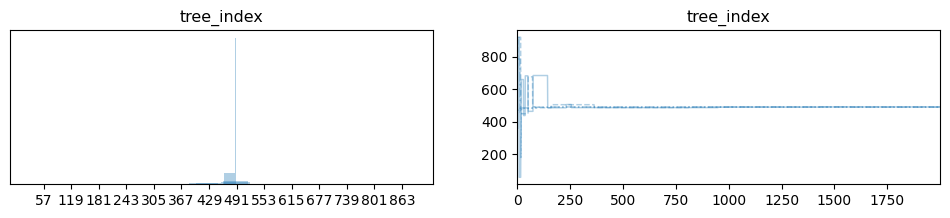

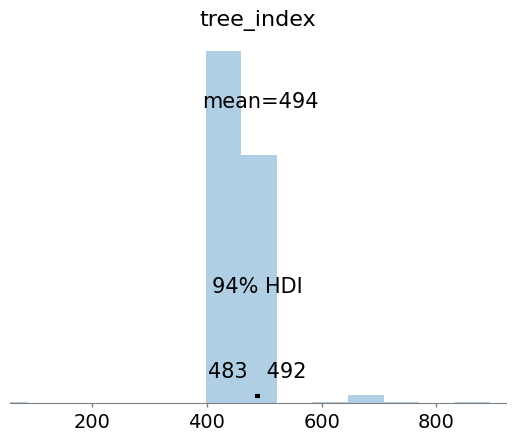

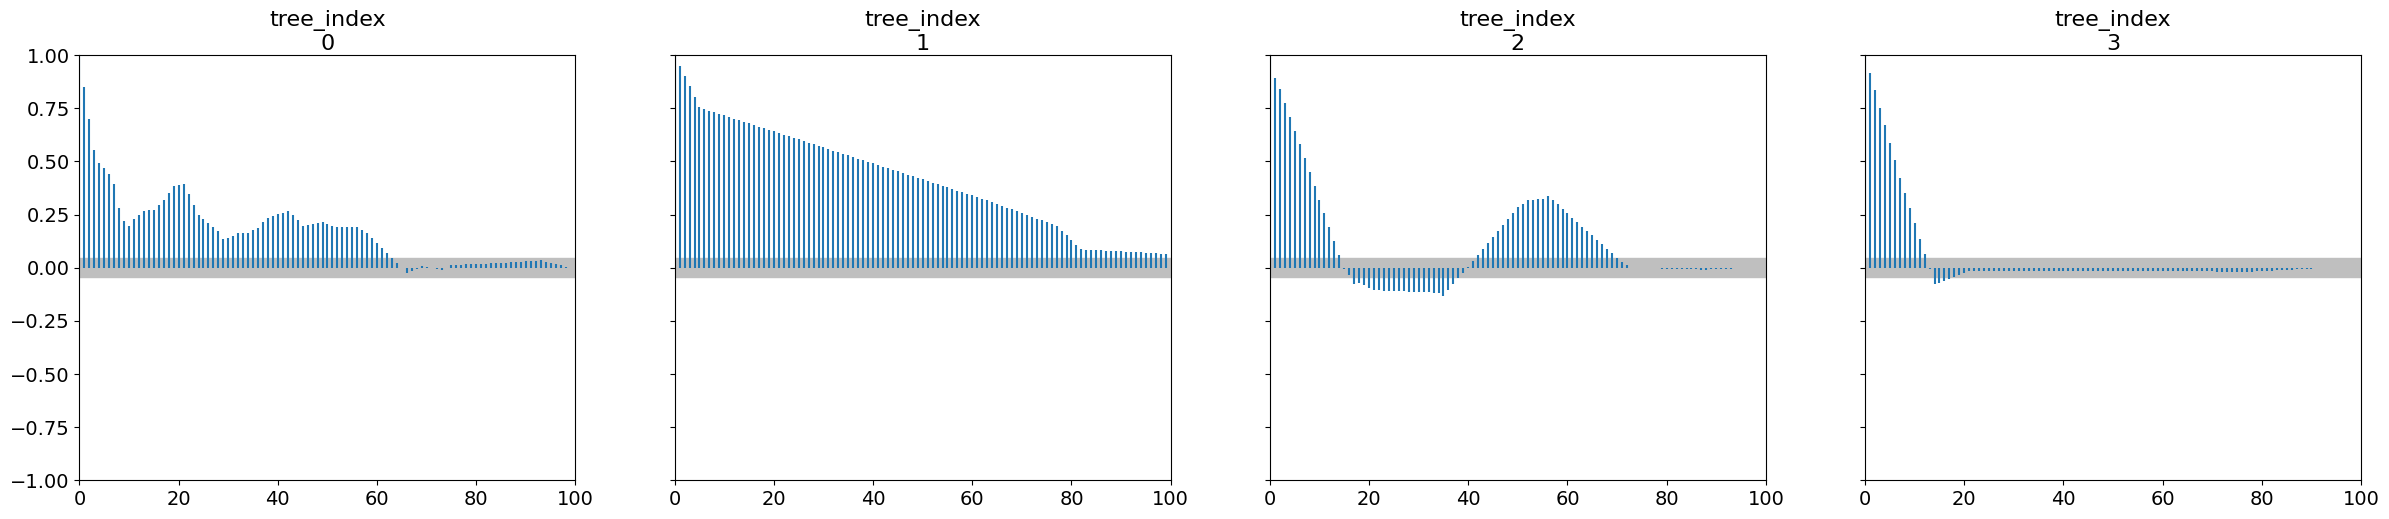

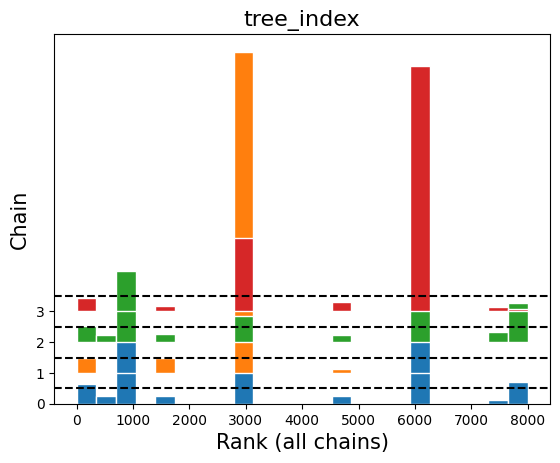

In [ ]:
cache = {}

def split_loglik_star_sm(X, y, split, maxiter=100, eps=1e-12):
    """
    ℓ*(split) using statsmodels Logit (unpenalized MLE).
    Returns the node log-likelihood at the MLE (float).
    Degenerate targets (all 0/1) → return 0.0 (supremum in the limit).
    """
    A, B = split
    mask = np.isin(y, A + B)
    if not np.any(mask):
        return 0.0
    s = np.isin(y[mask], B).astype(int)

    if s.min() == s.max():
        return 0.0
    Xsub = sm.add_constant(X[mask], has_constant="add")
    try:
        res = sm.Logit(s, Xsub).fit(disp=0, maxiter=maxiter, method="newton")
        # Direct log-likelihood at the MLE:
        return float(res.llf)
    except PerfectSeparationError:
        print("Perfect Separation Error.")
        return 0.0
    except Exception:
        # Any other numerical hiccup: treat as saturated/flat
        print("Failed to do normal so we are fitting regularized.")
        p = np.clip(sm.Logit(s, Xsub).fit_regularized(alpha=1e-6, L1_wt=0.0, maxiter=maxiter).predict(), eps, 1-eps)
        return float((s*np.log(p) + (1-s)*np.log(1-p)).sum())
        
def delta_loglik(X, y, sig_T, sig_Tstar):
    """Compute log L(T*) - log L(T) by only evaluating splits in the symmetric difference."""
    add = sig_Tstar - sig_T
    add_vals = []
    rem = sig_T - sig_Tstar
    rem_vals = []
    
    for s in add:
        if s not in cache:
            log_lik = split_loglik_star_sm(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        add_vals.append(log_lik)
    for s in rem:
        if s not in cache:
            log_lik = split_loglik_star_sm(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        rem_vals.append(log_lik)
    
    return sum(add_vals) - sum(rem_vals)

def tree_loglik_idx(idx):
    tot = 0.0
    for s in tree_signatures(trees_defined[idx]):
        v = cache.get(s)
        if v is None:
            v = split_loglik_star_sm(X, y, s); cache[s] = v
        tot += v
    return tot

# --- Independence-chain MH over a library of trees (computes on the fly) ----
def mh_independence_over_trees(trees, g, X, y, n_samples, rng_seed=42):
    """
    trees: list of ND trees (tuples (left_set, right_set, left_child, right_child))
    g: proposal pmf over the library (shape M), fixed (independence)
    X (n,p), y (n,)
    Returns: indices trace (n_samples,), optional cache for reuse/diagnostics
    """
    rng = Generator(PCG64(rng_seed))
    g = np.asarray(g, float)
    g = g / g.sum()
    log_g = np.log(g)
    M = len(trees)

    # Precompute signatures per tree (cheap, symbolic)
    sigs = [tree_signatures(T) for T in trees]
    # Initialize at the argmax under a quick heuristic (draw from g is fine too)
    i = int(rng.choice(M, p=g))

    trace = np.empty(n_samples, dtype=int)
    for t in range(n_samples):
        j = int(rng.choice(M, p=g))  # independence proposal
        dLL = delta_loglik(X, y, sigs[i], sigs[j])
        logR = dLL + (log_g[i] - log_g[j])   # MH accept log-ratio
        if np.log(rng.random()) < min(0.0, logR):
            i = j
        trace[t] = i
    return trace, cache

def tree_loglik_quick(T, X, y):
    total = 0.0
    for s in tree_signatures(T):
        if s not in cache:
            cache[s] = split_loglik_star_sm(X, y, s)
        total += cache[s]
    return total

# trace, c = mh_independence_over_trees(trees_defined, np.ones(len(trees_defined)), X, y, 250, rng_seed=2)

# Get the best tree from trace 
# best_found_index = np.bincount(trace).argmax()
# print(f"Index of best tree is: {best_found_index}")
# best_found_tree = trees_defined[best_found_index]

# if tuple(best) == best_found_tree:
#     print("The best tree is found by MH!")
# else:
#     print("The best tree is NOT found by MH.")
#     print("Best tree is:", best)
#     print("Our tree is:", best_found_tree)

# pick the settled index (choose ONE of these lines)

M = len(trees_defined)
# settled_idx = trace[-1]                               # last state
# left_idx  = (settled_idx - 1) % M
# right_idx = (settled_idx + 1) % M

# ll_settled = tree_loglik_idx(settled_idx)
# ll_left    = tree_loglik_idx(left_idx)
# ll_right   = tree_loglik_idx(right_idx)

# print("Settled idx:", trees_defined[settled_idx], "logL:", ll_settled)
# print("Left    idx:", trees_defined[left_idx],  "logL:", ll_left)
# print("Right   idx:", trees_defined[right_idx], "logL:", ll_right)
# print("Settled tree:", trees_defined[settled_idx])        

seeds = [5, 11, 42, 50]
traces = [mh_independence_over_trees(trees_defined, np.ones(len(trees_defined)), X, y, 2000, rng_seed=s)[0]
          for s in seeds]
settled = [tr[-1] for tr in traces]  # or mode of each tail as above
best_idx = max(settled, key=lambda i: tree_loglik_idx(i))
best = trees_defined[best_idx]
print("Best across chains idx:", best_idx, "logL:", tree_loglik_idx(best_idx))
print("Best tree across chains idx:", trees_defined[best_idx])
if sorted(tuple(best)) == sorted(best_prev_tree):
    print("The best tree is found by MH!")
else:
    print("The best tree is NOT found by MH.")
    print("Best tree is:", best_prev_tree)

viz_mh_trace(traces, burn=0)

# trace = [chain0, chain1, ...]  # each chain: (draws, k) or (draws,) for scalar
beta = np.stack([c if c.ndim == 2 else c[:, None] for c in traces], axis=0)  # (chain, draw, k)
idata = az.from_dict(posterior={"beta": beta})

az.plot_trace(idata, var_names="beta");          # trace + posterior
az.plot_posterior(idata, var_names="beta");      # posteriors + HDIs
az.plot_autocorr(idata, var_names="beta");       # ACF per chain
az.plot_rank(idata, var_names="beta");           # rank plots (mixing)
print(az.summary(idata, var_names="beta", round_to=2))  # R-hat, ESS, mean, sd, hdi

## 🇺🇸 MH - independent density 
General: Build a general density to pmf and sample from this as my g.

Use candidate pmf g(.) = 1 / (distance to k-th neighbour)^2

We map to 2d using cosine similarity then on this plot do 1/(dist to k-th neighbour)^2

In [ ]:
import numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import plotly.express as px
from generate_data import newick, breadth_first_splits, depth_first_splits
import matplotlib.pyplot as plt
import mpld3

from bokeh.plotting import figure, show
from bokeh.io import output_file, save
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Inferno256, Blues, BuGn, RdYlGn
from bokeh.transform import linear_cmap, factor_mark
from bokeh.models import LinearColorMapper, ColorBar, Title

import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, permutation_test_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from scipy.stats import kruskal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import silhouette_score
from bokeh.models import Div
from bokeh.layouts import row, column

import itertools
import ast
import re

import numpy as np
from sklearn.neighbors import NearestNeighbors

def check_label_fit(labels, y, coords):

    df_eval = pd.DataFrame({
        "score": y,
        "cluster": pd.Categorical(labels)   # no manual one-hot; just mark as categorical
    })

    # OLS with cluster fixed effects
    ols = smf.ols("score ~ C(cluster)", data=df_eval).fit()
    r2_in_sample = float(ols.rsquared)

    # ANOVA table (Type II)
    anova = sm.stats.anova_lm(ols, typ=2)

    # Sums of squares and dfs
    ss_between = float(anova.loc["C(cluster)", "sum_sq"])
    df_between = float(anova.loc["C(cluster)", "df"])
    ss_within  = float(anova.loc["Residual",   "sum_sq"])
    df_within  = float(anova.loc["Residual",   "df"])

    # Mean square within (pooled within-cluster variance estimate)
    ms_within = ss_within / df_within

    # Effect sizes:
    #   η²  = SS_between / (SS_between + SS_within)
    #   ω²  = (SS_between - df_between * MS_within) / (SS_total + MS_within)
    ss_total = ss_between + ss_within
    eta_sq   = ss_between / ss_total
    omega_sq = (ss_between - df_between * ms_within) / (ss_total + ms_within)

    # Optional: per-cluster descriptive stats
    per_cluster = df_eval.groupby("cluster")["score"].agg(["count", "mean", "std"]).sort_index()
    # print(per_cluster)

    # ----------------------------- (B) Mixed-effects ICC (random intercepts) -----------------------------
    # Model: score_ij = μ + u_j + ε_ij, with u_j ~ N(0, σ_u^2) for cluster j, ε_ij ~ N(0, σ^2)
    # ICC = σ_u^2 / (σ_u^2 + σ^2)
    md = sm.MixedLM.from_formula("score ~ 1", groups="cluster", data=df_eval)
    m  = md.fit(reml=True)  # REML for variance components

    # Between-cluster variance (random intercept variance)
    var_cluster = float(m.cov_re.iloc[0, 0])
    # Within-cluster (residual) variance
    var_resid   = float(m.scale)

    icc = var_cluster / (var_cluster + var_resid)

    sil = silhouette_score(coords, labels, metric="euclidean")

    return_values = {
        "r2_in_sample": r2_in_sample,
        "eta_sq": eta_sq,
        "omega_sq": omega_sq,
        "icc": icc,
        "sil": sil
    }

    return return_values

def embed_tree(df, embeding):
    if embeding == "bfs":
        # newicks = [str(breadth_first_splits(t)) for t in df["tree"]]
        df["tree_encoded"] = df["tree"].apply(lambda x: str(breadth_first_splits(x)))
    elif embeding == "dfs":
        # newicks = [str(depth_first_splits(t)) for t in df["tree"]]
        df["tree_encoded"] = df["tree"].apply(lambda x: str(depth_first_splits(x)))
    else:
        embeding = "newick"
        # newicks = [newick(t) for t in df["tree"]]
        df["tree_encoded"] = df["tree"].apply(newick)
    # newicks = sorted(newicks)
    # df['tree_encoded'] = newicks
    df = df.sort_values(by='tree_encoded')
    return df

def html_similarity_scatter(df, embeding="newick", ngram_range=(2,4), n_clusters=4, to_html=None, analyzer=None, tokenize=None, vec=None, cards_per_row=None):

    # Newick → TF-IDF → cosine similarity
    df = embed_tree(df, embeding)
    newicks = df["tree_encoded"]

    # --- unify vectorizer so we can get feature names later ---
    if analyzer is not None:
        vec_used = TfidfVectorizer(analyzer=analyzer, lowercase=False, norm="l2")
    elif vec is not None:
        vec_used = vec
    elif tokenize is not None:
        vec_used = TfidfVectorizer(analyzer="word", token_pattern=tokenize)
    else:
        vec_used = TfidfVectorizer(analyzer="char", ngram_range=ngram_range, norm="l2")

    X = vec_used.fit_transform(newicks)
    feature_names = np.array(vec_used.get_feature_names_out())

    S = cosine_similarity(X)                         # similarity (absolute; no reordering)
    D = 1.0 - S                                      # distance for embedding

    # MDS: finds 2D coords whose Euclidean distances best match the given distance matrix
    coords = MDS(n_components=2, dissimilarity="precomputed", random_state=0).fit_transform(D)
    labels = KMeans(n_clusters=n_clusters, n_init=20, random_state=0).fit_predict(coords)

    all_vals = check_label_fit(labels, df["score"].to_numpy(float), coords)
    r2_in_sample, eta_sq, omega_sq, icc, sil = all_vals["r2_in_sample"], all_vals["eta_sq"], all_vals["omega_sq"], all_vals["icc"], all_vals["sil"]

    print(f"In-sample R^2 = {r2_in_sample:.3f} — fraction of variance in accuracy explained by cluster labels in this sample (fixed-effects OLS).")
    print(f"η² = {eta_sq:.3f} — ANOVA effect size: proportion of total accuracy variance attributable to differences between clusters (in-sample).")
    print(f"ω² = {omega_sq:.3f} — bias-corrected effect size estimating the population proportion of accuracy variance explained by cluster membership.")
    print(f"ICC = {icc:.3f} — intraclass correlation from a random-intercepts model: share of accuracy variance due to between-cluster differences (0=no signal, 1=all between-cluster).")
    print(f"Silhouette = {sil:.3f} — mean of (b-a)/max(a,b), comparing a=dist to cluster center to b=nearest-other-cluster distance (−1 bad, 0 overlap, +1 well-separated).")

    cluster_str = labels.astype(str)

    # color by accuracy (min → max gradient)
    scores = df["score"].to_numpy(float)
    vmin, vmax = float(scores.min()), float(scores.max())
    out = df[["tree", "score"]]
    out[embeding] = newicks
    out["cluster"] = labels.astype(str)

    cluster_levels = sorted(set(cluster_str))
    marker_list = [
        "circle", "square", "triangle", "diamond", "inverted_triangle",
        "star", "hex", "circle_cross", "circle_x", "circle_dot",
        "square_cross", "square_x", "square_dot",
        "cross", "x", "asterisk", "star", "hex",
        "plus", "dash", "dot",
        "diamond_cross", "diamond_dot",
        "triangle_dot", "triangle_pin",
        "star_dot", "square_pin",
    ][:len(cluster_levels)]
    marker_map = dict(zip(cluster_levels, marker_list))
    marker_col = [marker_map[c] for c in cluster_str]  # one marker per point

    src = ColumnDataSource(dict(
        x=coords[:,0], y=coords[:,1],
        score=df["score"].astype(float).to_numpy(),
        cluster=labels, newick=newicks,  marker=marker_col, 
        tree=[str(t) for t in df["tree"]],
    ))
    p = figure(title=f"Trees (MDS of cosine on {embeding}) with {n_clusters}-clusters", width=800, height=520,
            tools="pan,wheel_zoom,reset,save")
    mapper = linear_cmap("score", palette=list(RdYlGn.get(8))[::-1], low=src.data["score"].min(), high=src.data["score"].max())

    p.scatter("x", "y", source=src, size=9, marker="marker", color=mapper, line_color="#222", alpha=0.9)

    adj_r2 = float(r2_in_sample)
    w2     = float(omega_sq)
    sil_v  = float(sil)
    def tag(v, good, ok):
        return "🟢 good" if v >= good else ("🟡 fine" if v >= ok else "🔴 bad")

    r2_tag  = tag(adj_r2, good=0.50, ok=0.20)
    w2_tag  = tag(w2,     good=0.50, ok=0.20)
    sil_tag = tag(sil_v,  good=0.50, ok=0.25)

    acc_div = Div(text=f"""
    <div style="border:1px solid #ddd;border-radius:8px;padding:10px;margin-top:6px;background:#fafafa; font-size:13px;">
    <h4 style="margin:0 0 6px 0;">Accuracy Fit</h4>
    <div style="margin-bottom:6px;">
        <strong>Adj&nbsp;R²:</strong> {adj_r2:.3f} &nbsp;{r2_tag}<br>
        <meter min="0" max="1" low="0.20" high="0.50" optimum="0.70" value="{adj_r2:.4f}" style="width:100%"></meter>
    </div>
    <div>
        <strong>ω²:</strong> {w2:.3f} &nbsp;{w2_tag}<br>
        <meter min="0" max="1" low="0.20" high="0.50" optimum="0.70" value="{w2:.4f}" style="width:100%"></meter>
    </div>
    <div style="margin-top:6px;"><small>
        R²: share of accuracy variance explained by cluster labels (in-sample). 
        <br>
        ω²: is bias-corrected R².
    </small></div>
    </div>
    """, width=int(p.width/2)-12)

    geo_div = Div(text=f"""
    <div style="border:1px solid #ddd;border-radius:8px;padding:10px;margin-top:6px;background:#fafafa; font-size:13px;">
    <h4 style="margin:0 0 6px 0;">Geometric Fit</h4>
    <div>
        <strong>Silhouette:</strong> {sil_v:.3f} &nbsp;{sil_tag}<br>
        <meter min="-1" max="1" low="0.25" high="0.50" optimum="0.7" value="{sil_v:.4f}" style="width:100%"></meter>
    </div>
    <div style="margin-top:6px;"><small>
        Silhouette: mean of (b-a)/max(a,b), comparing a=dist to cluster center to b=nearest-other-cluster distance.
    </small></div>
    </div>
    """, width=int(p.width/2)-12)

    cbar = ColorBar(color_mapper=mapper.transform)
    p.add_layout(cbar, 'right')

    print(f"In-sample R^2 = {r2_in_sample:.3f} — fraction of variance in accuracy explained by cluster labels in this sample (fixed-effects OLS).")
    print(f"η² = {eta_sq:.3f} — ANOVA effect size: proportion of total accuracy variance attributable to differences between clusters (in-sample).")
    print(f"ω² = {omega_sq:.3f} — bias-corrected effect size estimating the population proportion of accuracy variance explained by cluster membership.")
    print(f"ICC = {icc:.3f} — intraclass correlation from a random-intercepts model: share of accuracy variance due to between-cluster differences (0=no signal, 1=all between-cluster).")
    print(f"Silhouette = {sil:.3f} — mean of (b-a)/max(a,b), comparing a=dist to cluster center to b=nearest-other-cluster distance (−1 bad, 0 overlap, +1 well-separated).")

    p.add_tools(HoverTool(tooltips=[("acc","@score{0.000}"),("tree","@newick")]))

    X = X.tocsr(); fn = feature_names; L = labels; mm = marker_map
    cols = cards_per_row if cards_per_row is not None else 4

    # 1) ω² per feature across all clusters
    g = pd.Series(L, name='g')
    w2 = np.zeros(X.shape[1])
    for j in range(X.shape[1]):
        y = pd.Series(X[:, j].toarray().ravel(), name='y')
        aov = sm.stats.anova_lm(ols('y ~ C(g)', data=pd.concat([y, g], axis=1)).fit(), typ=2)
        ss, df = aov.loc['C(g)', ['sum_sq','df']]
        ssr, dfr = aov.loc['Residual', ['sum_sq','df']]
        ms = ssr / dfr
        w2[j] = max((ss - df*ms) / (ss + ssr + ms), 0.0)   # ω²

    # simple icon map for your existing marker names
    icon = {"circle":"●","square":"■","triangle":"▲","diamond":"◆","inverted_triangle":"▼","star":"✶","hex":"⬢",
            "circle_cross":"⊕","circle_x":"⊗","circle_dot":"◉","square_cross":"⊞","square_x":"☒","square_dot":"▣",
            "cross":"✚","x":"✕","asterisk":"✱","plus":"＋","dash":"–","dot":"•","diamond_cross":"⟐","diamond_dot":"◈",
            "triangle_dot":"▲","triangle_pin":"▲","star_dot":"✶","square_pin":"■"}

    # 2) Cards per cluster: pick terms by in-cluster mean, show ω² bars
    cards = []
    for c in range(n_clusters):
        idx = np.where(L == c)[0]
        if not idx.size: continue
        mc = X[idx].mean(0).A1
        top = mc.argsort()[-6:][::-1]           # show common-in-cluster terms
        vmax = float(w2[top].max()) or 1.0
        rows = ''.join(
            f'<div style="display:flex;gap:8px;align-items:center;margin:4px 0;">'
            f'<span style="min-width:150px;white-space:nowrap;overflow:hidden;text-overflow:ellipsis;">{fn[i]}</span>'
            f'<meter min="0" max="{vmax:.6f}" value="{w2[i]:.6f}" style="flex:1;height:14px;"></meter>'
            f'<span style="min-width:56px;text-align:right;">{w2[i]:.2f}</span></div>'
            for i in top
        )
        mname = mm[str(c)]
        cards.append(
            f'<div style="border:1px solid #ccc;border-radius:12px;padding:12px;background:#F8FAFD;">'
            f'<div style="display:flex;justify-content:space-between;align-items:center;margin-bottom:6px;">'
            f'<b>Cluster {c}</b><span><small>n={idx.size}</small>&nbsp;<span style="font-size:22px;">{icon.get(mname,"•")}</span></span></div>'
            f'{rows}</div>'
        )

    cluster_div = Div(text=
    f'<div style="border:1px solid #ddd;border-radius:12px;padding:12px;margin-top:8px;background:#fff;">'
    f'<h4 style="margin:0 0 8px 0;">Cluster Content Summary — ω² (variance explained by clusters)</h4>'
    f'<div style="display:grid;grid-template-columns:repeat({cols},1fr);gap:12px;">{"".join(cards)}</div>'
    f'<div style="margin-top:6px;font-size:12px;"><em>ω²: bias-corrected ANOVA R² per term (higher = more of that term’s variance is due to cluster differences).</em></div>'
    f'</div>', width=p.width)

    layout = column(p, row(acc_div, geo_div), cluster_div, sizing_mode="stretch_width")

    if to_html is not None:
        output_file(to_html); 
        save(layout)
        show(layout)

    return S, coords

def map_all_trees(df, embeding="newick", ngram_range=(2,4), analyzer=None, tokenize=None, vec=None):

    # Newick → TF-IDF → cosine similarity
    df = embed_tree(df, embeding)
    newicks = df["tree_encoded"]

    # --- unify vectorizer so we can get feature names later ---
    if analyzer is not None:
        vec_used = TfidfVectorizer(analyzer=analyzer, lowercase=False, norm="l2")
    elif vec is not None:
        vec_used = vec
    elif tokenize is not None:
        vec_used = TfidfVectorizer(analyzer="word", token_pattern=tokenize)
    else:
        vec_used = TfidfVectorizer(analyzer="char", ngram_range=ngram_range, norm="l2")

    X = vec_used.fit_transform(newicks)
    feature_names = np.array(vec_used.get_feature_names_out())

    S = cosine_similarity(X)                         # similarity (absolute; no reordering)
    D = 1.0 - S                                      # distance for embedding

    # MDS: finds 2D coords whose Euclidean distances best match the given distance matrix
    coords = MDS(n_components=2, dissimilarity="precomputed", random_state=0).fit_transform(D)
 
    return S, coords

NUMBER_OF_CLASSES = len(categories)

def split_analyzer(doc):
    splits = ast.literal_eval(doc) if isinstance(doc, str) else doc
    # max_depth = 4
    toks = []
    for d, (L, R) in enumerate(splits):

        L = tuple(sorted(L)) 
        R = tuple(sorted(R))   # order inside each side
        c = [L, R]
        c.sort(key=len, reverse=True)
        A = c[0]
        B = c[1]
        # depth_prefix = f"d{d}|"
        w = (NUMBER_OF_CLASSES - 2) - min(d, NUMBER_OF_CLASSES - 3)
        new = NUMBER_OF_CLASSES - d
        toks.extend([f"split:{A}|{B}"])

        toks.extend([f"sz:{len(A)}|{len(B)}"]*new)

        toks.extend([f"group:{A}"]*len(A))
        toks.extend([f"group:{B}"]*len(B))

        # toks.extend([f"group:{A}"])
        # toks.extend([f"group:{B}"])
        # # toks.append(f"group:{B}")
        
        # encourage grouping via co-membership pairs (repeatable across trees)
        for side in (A, B):
            for i, j in itertools.combinations(side, 2):
                toks.extend([f"pair:{i}-{j}"])
                # toks.extend([f"pair:{i}-{j}"]*(d+1))
    return toks

embeding = "bfs"

n_clusters=15
ngram_range=(2,4)
note=""
# vectorizer: encourage overlap, trim one-offs
vec = TfidfVectorizer(
    analyzer=split_analyzer,
    # lowercase=False, norm="l2", binary=True, min_df=2, sublinear_tf=True
)
    
info_df, coords = map_all_trees(df_trees, embeding=embeding, vec=vec)
df_trees["x_coord"] = coords[:,0]
df_trees["y_coord"] = coords[:,1]

# To increase acceptance rate, decrease power, increase k and eps
power=2
k=3

Z = df_trees[['x_coord','y_coord']].to_numpy(float)
nn = NearestNeighbors(n_neighbors=k+1).fit(Z)
d, _ = nn.kneighbors(Z, n_neighbors=k+1)   # first neighbor is self
dk = d[:, k]                               # 
D = 1.0 / (dk + 1e-2)**power
g = D / D.sum()

df_trees['prob_dist'] = g

/Users/22701987/Documents/code/simulation/venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Best across chains idx: 13 logL: -45812.45946925831
Best tree across chains idx: (((0, 2, 3), (1,)), ((0, 2), (3,)), ((0,), (2,)))
The best tree is NOT found by MH.
Best tree is: (((0, 2, 3), (1,)), ((0, 3), (2,)), ((0,), (3,)))
            mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tree_index  12.6  1.5     8.0     13.0       0.22     0.37     57.44   

            ess_tail  r_hat  
tree_index     43.97   1.09  
Acceptance per chain: ['0.030', '0.010', '0.030', '0.030', '0.040', '0.010', '0.010'] | overall: 0.023


(Inference data with groups:
 	> posterior,
 [0.030303030303030304,
  0.010101010101010102,
  0.030303030303030304,
  0.030303030303030304,
  0.04040404040404041,
  0.010101010101010102,
  0.010101010101010102],
 0.023088023088023095)

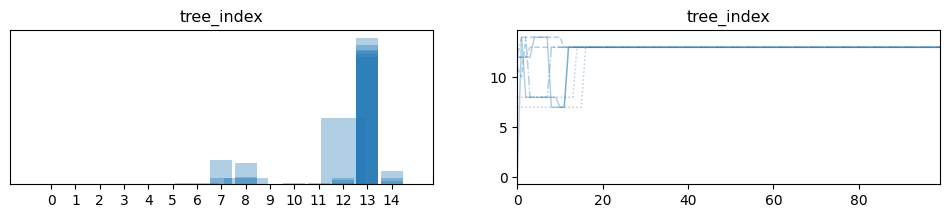

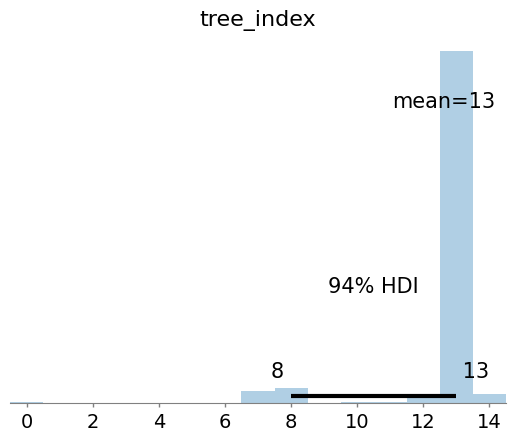

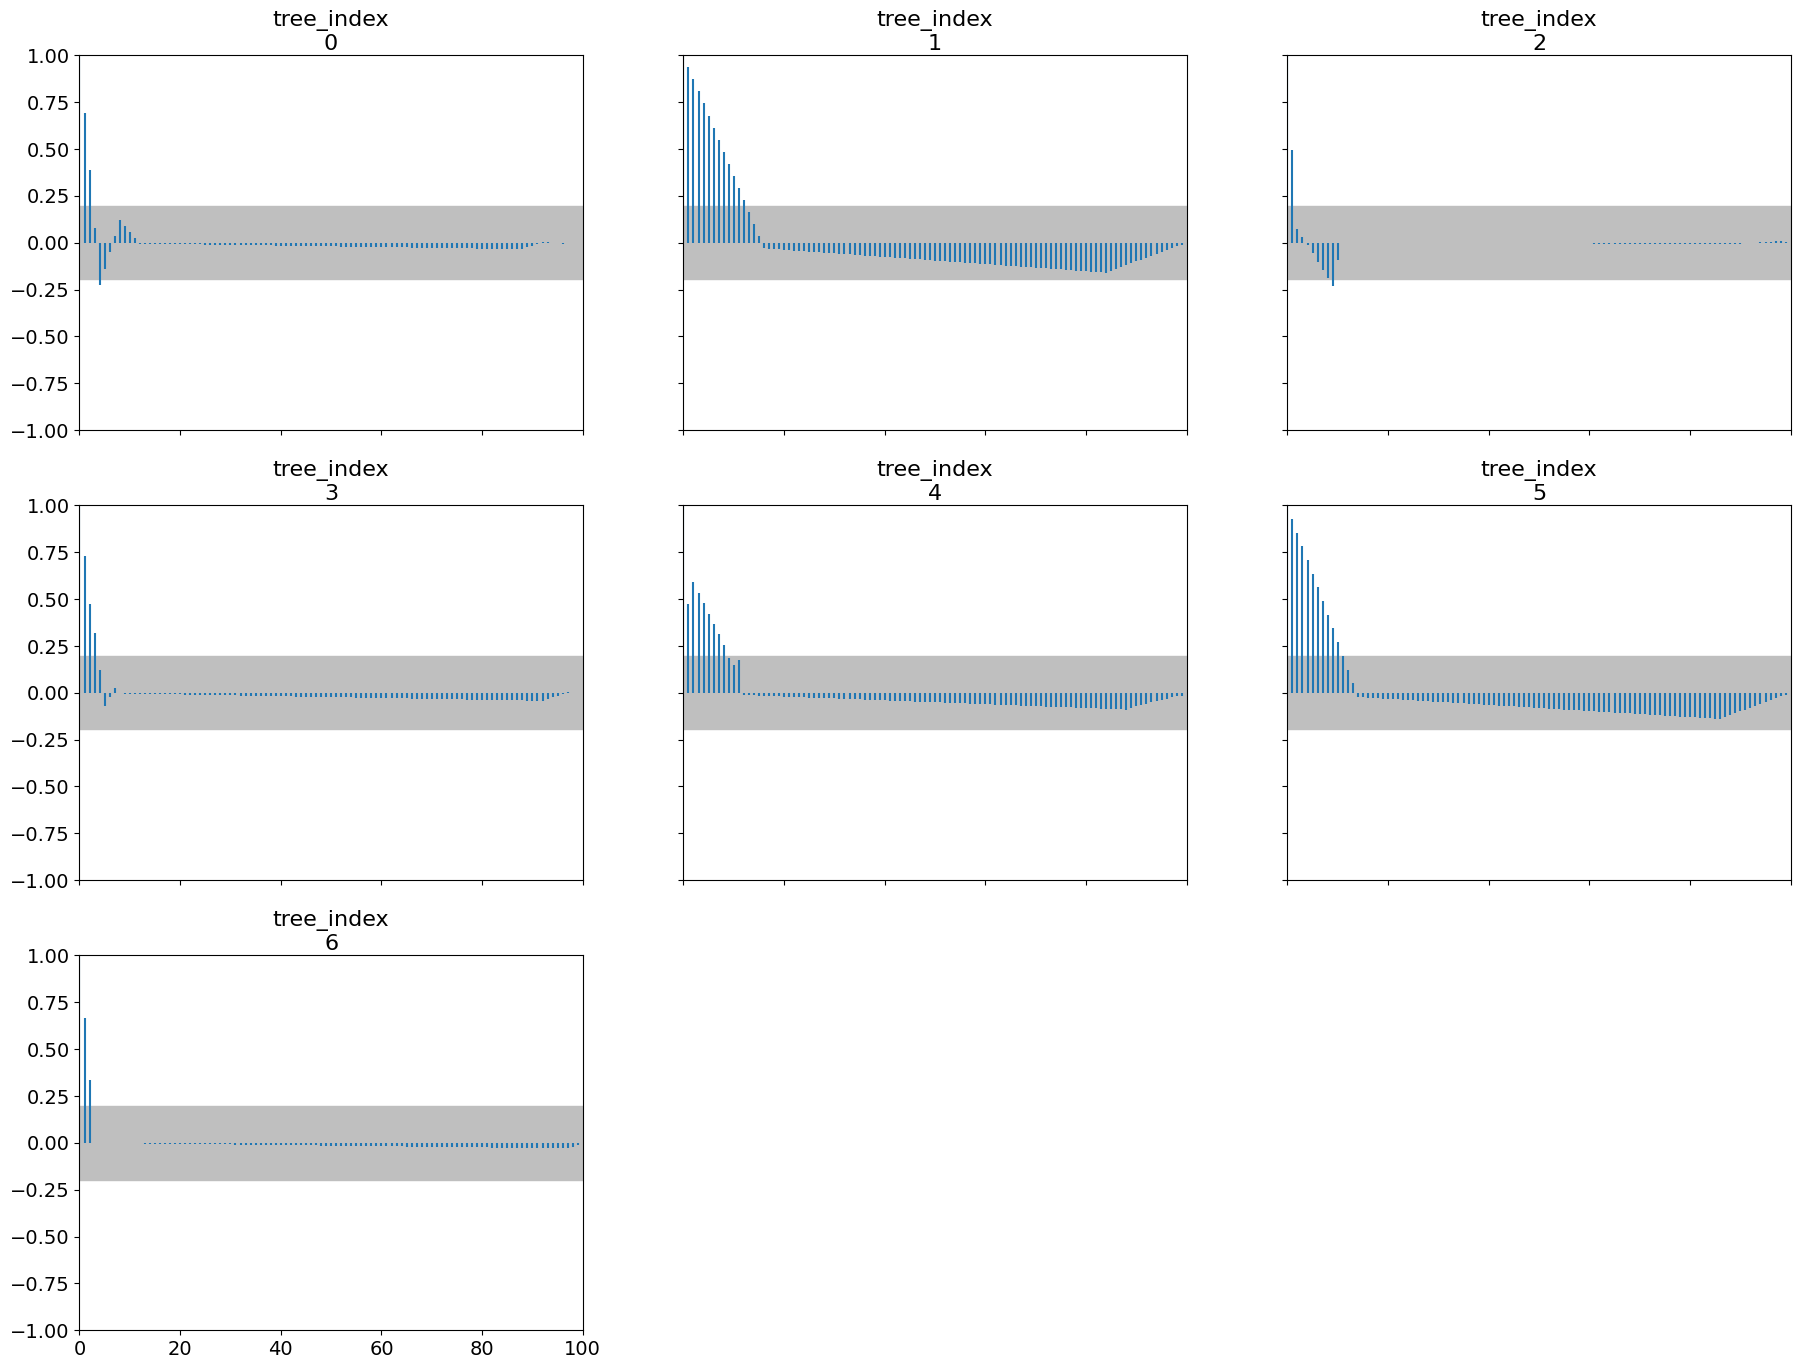

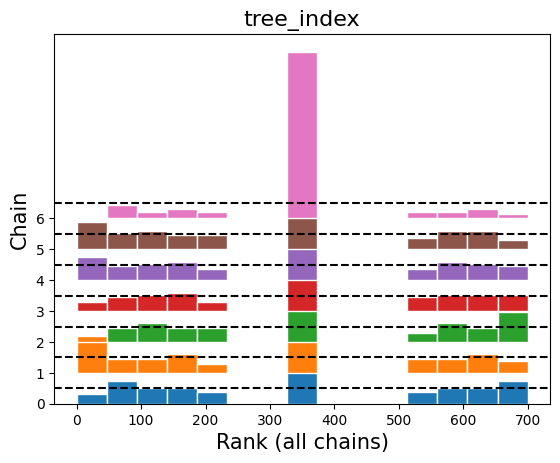

In [304]:
cache = {}

def split_loglik_star_sm(X, y, split, maxiter=100, eps=1e-12):
    """
    ℓ*(split) using statsmodels Logit (unpenalized MLE).
    Returns the node log-likelihood at the MLE (float).
    Degenerate targets (all 0/1) → return 0.0 (supremum in the limit).
    """
    A, B = split
    mask = np.isin(y, A + B)
    if not np.any(mask):
        return 0.0
    s = np.isin(y[mask], B).astype(int)

    if s.min() == s.max():
        return 0.0
    Xsub = sm.add_constant(X[mask], has_constant="add")
    try:
        res = sm.Logit(s, Xsub).fit(disp=0, maxiter=maxiter, method="newton")
        # Direct log-likelihood at the MLE:
        return float(res.llf)
    except PerfectSeparationError:
        print("Perfect Separation Error.")
        return 0.0
    except Exception:
        # Any other numerical hiccup: treat as saturated/flat
        print("Failed to do normal so we are fitting regularized.")
        p = np.clip(sm.Logit(s, Xsub).fit_regularized(alpha=1e-6, L1_wt=0.0, maxiter=maxiter).predict(), eps, 1-eps)
        return float((s*np.log(p) + (1-s)*np.log(1-p)).sum())
        
def delta_loglik(X, y, sig_T, sig_Tstar):
    """Compute log L(T*) - log L(T) by only evaluating splits in the symmetric difference."""
    add = sig_Tstar - sig_T
    add_vals = []
    rem = sig_T - sig_Tstar
    rem_vals = []
    
    for s in add:
        if s not in cache:
            log_lik = split_loglik_star_sm(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        add_vals.append(log_lik)
    for s in rem:
        if s not in cache:
            log_lik = split_loglik_star_sm(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        rem_vals.append(log_lik)
    
    return sum(add_vals) - sum(rem_vals)

def tree_loglik_idx(idx):
    tot = 0.0
    for s in tree_signatures(trees_defined[idx]):
        v = cache.get(s)
        if v is None:
            v = split_loglik_star_sm(X, y, s); cache[s] = v
        tot += v
    return tot

# --- Independence-chain MH over a library of trees (computes on the fly) ----
def mh_independence_density_trees(trees, g, X, y, n_samples, rng_seed=42):
    """
    trees: list of ND trees (tuples (left_set, right_set, left_child, right_child))
    g: proposal pmf over the library (shape M), fixed (independence)
    X (n,p), y (n,)
    Returns: indices trace (n_samples,), optional cache for reuse/diagnostics
    """
    rng = Generator(PCG64(rng_seed))
    g = np.asarray(g, float)
    # g = g / g.sum()
    log_g = np.log(g)
    M = len(trees)

    # Precompute signatures per tree (cheap, symbolic)
    sigs = [tree_signatures(T) for T in trees]
    # Initialize at the argmax under a quick heuristic (draw from g is fine too)
    i = int(rng.choice(M, p=g))

    trace = np.empty(n_samples, dtype=int)
    for t in range(n_samples):
        j = int(rng.choice(M, p=g))  # independence proposal
        dLL = delta_loglik(X, y, sigs[i], sigs[j])
        logR = dLL + (log_g[i] - log_g[j])   # MH accept log-ratio
        if np.log(rng.random()) < min(0.0, logR):
            i = j
        trace[t] = i
    return trace, cache

seeds = [5, 11, 42, 50, 60, 69, 100]
traces = [mh_independence_density_trees(df_trees["tree"], df_trees["prob_dist"], X, y, 100, rng_seed=s)[0]
          for s in seeds]
settled = [tr[-1] for tr in traces]  # or mode of each tail as above
best_idx = max(settled, key=lambda i: tree_loglik_idx(i))
best = trees_defined[best_idx]
print("Best across chains idx:", best_idx, "logL:", tree_loglik_idx(best_idx))
print("Best tree across chains idx:", trees_defined[best_idx])
if sorted(tuple(best)) == sorted(best_prev_tree):
    print("The best tree is found by MH!")
else:
    print("The best tree is NOT found by MH.")
    print("Best tree is:", best_prev_tree)

viz_mh_trace(traces, burn=0)

## 🔗 MH - dependent density
General: Build a density from each tree to all the other trees. I use gaussian density given each tree, but this could be cauchy or any other one. 

Use candidate g(Tj | Ti) = exp( - dist(Ti, Tj) ^2 / (2 scale^2) ) / Z_i

where  Z_i = sum_{n=1..M} exp( - dist(Ti - Tn)^2 / (2 scale^2) )

and dist is Euclidean distance on my cosine similarity map. 



In [323]:
def check_label_fit(labels, y, coords):

    df_eval = pd.DataFrame({
        "score": y,
        "cluster": pd.Categorical(labels)   # no manual one-hot; just mark as categorical
    })

    # OLS with cluster fixed effects
    ols = smf.ols("score ~ C(cluster)", data=df_eval).fit()
    r2_in_sample = float(ols.rsquared)

    # ANOVA table (Type II)
    anova = sm.stats.anova_lm(ols, typ=2)

    # Sums of squares and dfs
    ss_between = float(anova.loc["C(cluster)", "sum_sq"])
    df_between = float(anova.loc["C(cluster)", "df"])
    ss_within  = float(anova.loc["Residual",   "sum_sq"])
    df_within  = float(anova.loc["Residual",   "df"])

    # Mean square within (pooled within-cluster variance estimate)
    ms_within = ss_within / df_within

    # Effect sizes:
    #   η²  = SS_between / (SS_between + SS_within)
    #   ω²  = (SS_between - df_between * MS_within) / (SS_total + MS_within)
    ss_total = ss_between + ss_within
    eta_sq   = ss_between / ss_total
    omega_sq = (ss_between - df_between * ms_within) / (ss_total + ms_within)

    # Optional: per-cluster descriptive stats
    per_cluster = df_eval.groupby("cluster")["score"].agg(["count", "mean", "std"]).sort_index()
    # print(per_cluster)

    # ----------------------------- (B) Mixed-effects ICC (random intercepts) -----------------------------
    # Model: score_ij = μ + u_j + ε_ij, with u_j ~ N(0, σ_u^2) for cluster j, ε_ij ~ N(0, σ^2)
    # ICC = σ_u^2 / (σ_u^2 + σ^2)
    md = sm.MixedLM.from_formula("score ~ 1", groups="cluster", data=df_eval)
    m  = md.fit(reml=True)  # REML for variance components

    # Between-cluster variance (random intercept variance)
    var_cluster = float(m.cov_re.iloc[0, 0])
    # Within-cluster (residual) variance
    var_resid   = float(m.scale)

    icc = var_cluster / (var_cluster + var_resid)

    sil = silhouette_score(coords, labels, metric="euclidean")

    return_values = {
        "r2_in_sample": r2_in_sample,
        "eta_sq": eta_sq,
        "omega_sq": omega_sq,
        "icc": icc,
        "sil": sil
    }

    return return_values

def embed_tree(df, embeding):
    if embeding == "bfs":
        # newicks = [str(breadth_first_splits(t)) for t in df["tree"]]
        df["tree_encoded"] = df["tree"].apply(lambda x: str(breadth_first_splits(x)))
    elif embeding == "dfs":
        # newicks = [str(depth_first_splits(t)) for t in df["tree"]]
        df["tree_encoded"] = df["tree"].apply(lambda x: str(depth_first_splits(x)))
    else:
        embeding = "newick"
        # newicks = [newick(t) for t in df["tree"]]
        df["tree_encoded"] = df["tree"].apply(newick)
    # newicks = sorted(newicks)
    # df['tree_encoded'] = newicks
    df = df.sort_values(by='tree_encoded')
    return df

def map_all_trees(df, embeding="newick", ngram_range=(2,4), analyzer=None, tokenize=None, vec=None):

    # Newick → TF-IDF → cosine similarity
    df = embed_tree(df, embeding)
    newicks = df["tree_encoded"]

    # --- unify vectorizer so we can get feature names later ---
    if analyzer is not None:
        vec_used = TfidfVectorizer(analyzer=analyzer, lowercase=False, norm="l2")
    elif vec is not None:
        vec_used = vec
    elif tokenize is not None:
        vec_used = TfidfVectorizer(analyzer="word", token_pattern=tokenize)
    else:
        vec_used = TfidfVectorizer(analyzer="char", ngram_range=ngram_range, norm="l2")

    X = vec_used.fit_transform(newicks)
    feature_names = np.array(vec_used.get_feature_names_out())

    S = cosine_similarity(X)                         # similarity (absolute; no reordering)
    D = 1.0 - S                                      # distance for embedding

    # MDS: finds 2D coords whose Euclidean distances best match the given distance matrix
    coords = MDS(n_components=2, dissimilarity="precomputed", random_state=0).fit_transform(D)
 
    return S, coords

NUMBER_OF_CLASSES = len(categories)
def split_analyzer(doc):
    splits = ast.literal_eval(doc) if isinstance(doc, str) else doc
    # max_depth = 4
    toks = []
    for d, (L, R) in enumerate(splits):

        L = tuple(sorted(L)) 
        R = tuple(sorted(R))   # order inside each side
        c = [L, R]
        c.sort(key=len, reverse=True)
        A = c[0]
        B = c[1]
        # depth_prefix = f"d{d}|"
        w = (NUMBER_OF_CLASSES - 2) - min(d, NUMBER_OF_CLASSES - 3)
        new = NUMBER_OF_CLASSES - d
        toks.extend([f"split:{A}|{B}"])

        toks.extend([f"sz:{len(A)}|{len(B)}"]*new)

        toks.extend([f"group:{A}"]*len(A))
        toks.extend([f"group:{B}"]*len(B))

        # toks.extend([f"group:{A}"])
        # toks.extend([f"group:{B}"])
        # # toks.append(f"group:{B}")
        
        # encourage grouping via co-membership pairs (repeatable across trees)
        for side in (A, B):
            for i, j in itertools.combinations(side, 2):
                toks.extend([f"pair:{i}-{j}"])
                # toks.extend([f"pair:{i}-{j}"]*(d+1))
    return toks

embeding = "bfs"

n_clusters=15
ngram_range=(2,4)
note=""
# vectorizer: encourage overlap, trim one-offs
vec = TfidfVectorizer(
    analyzer=split_analyzer
)
    
info_df, coords = map_all_trees(df_trees, embeding=embeding, vec=vec)
df_trees["x_coord"] = coords[:,0]
df_trees["y_coord"] = coords[:,1]

# To increase acceptance rate, decrease power, increase k and eps
Z  = df_trees[['x_coord','y_coord']].to_numpy(float)

D = np.linalg.norm(Z[:, None, :] - Z[None, :, :], axis=2)  # pairwise distances
nn = np.where(D > 0, D, np.inf).min(axis=1)                # nearest neighbor per point
scale = 500*float(np.median(nn))                               # Scale for gaussian, increase for more acceptance
print(scale)

def g_sample_gaussian(Z, i, rng, scale):
    r = np.linalg.norm(Z - Z[i], axis=1)                       # distances from i to all
    w = np.exp(-(r*r) / (2*scale*scale))                       # Gaussian weights
    Zi = w.sum()
    j  = int(rng.choice(len(Z), p=w / Zi))                     # sample next index

    rj = np.linalg.norm(Z - Z[j], axis=1)                      # distances from j to all
    Zj = np.exp(-(rj*rj) / (2*scale*scale)).sum()

    return j, (np.log(Zi) - np.log(Zj))

/Users/22701987/Documents/code/simulation/venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


2.65177181773999


In [322]:
import numpy as np
from dadapy import Data

# Build once
Z = df_trees[['x_coord','y_coord']].to_numpy(float)
D = Data(Z)
D.compute_distances(maxk=Z.shape[0]-1)     # full distance table
scale = float(np.median(D.distances[:, 1]))    # median 1-NN distance

def q_sample_dadapy_gauss(D: Data, i, rng, scale):
    w  = np.exp(-(D.distances[i]**2) / (2*scale*scale))
    Zi = w.sum()
    j  = int(rng.choice(D.dist_indices[i], p=w / Zi))

    wj = np.exp(-(D.distances[j]**2) / (2*scale*scale))
    Zj = wj.sum()
    return j, (np.log(Zi) - np.log(Zj))

KeyboardInterrupt: 

       Best across chains idx: 762 logL: -88348.48996424173
Best tree across chains idx: (((0, 1, 3, 4, 5), (2,)), ((0, 1, 3), (4, 5)), ((1, 3), (0,)), ((1,), (3,)), ((4,), (5,)))
The best tree is found by MH!
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tree_index  721.18  98.48   500.0    785.0      26.21    23.88     18.86   

            ess_tail  r_hat  
tree_index     25.48    1.4  
Acceptance per chain: ['0.000', '0.003', '0.003', '0.002', '0.003', '0.002', '0.004'] | overall: 0.002


(Inference data with groups:
 	> posterior,
 [0.0,
  0.0025012506253126563,
  0.0025012506253126563,
  0.0015007503751875938,
  0.0025012506253126563,
  0.0015007503751875938,
  0.00400200100050025],
 0.0020724648038304865)

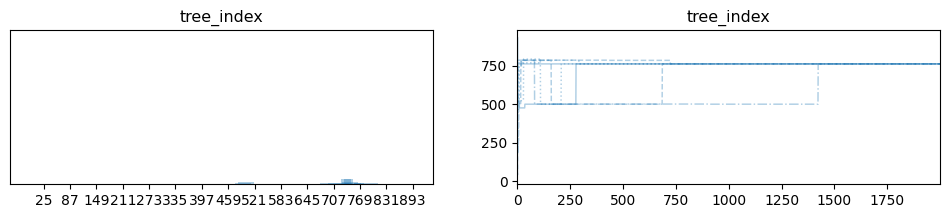

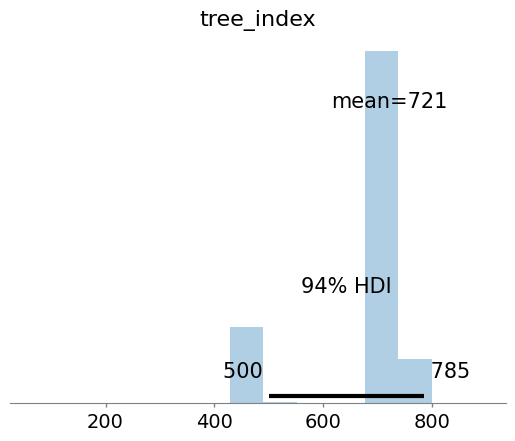

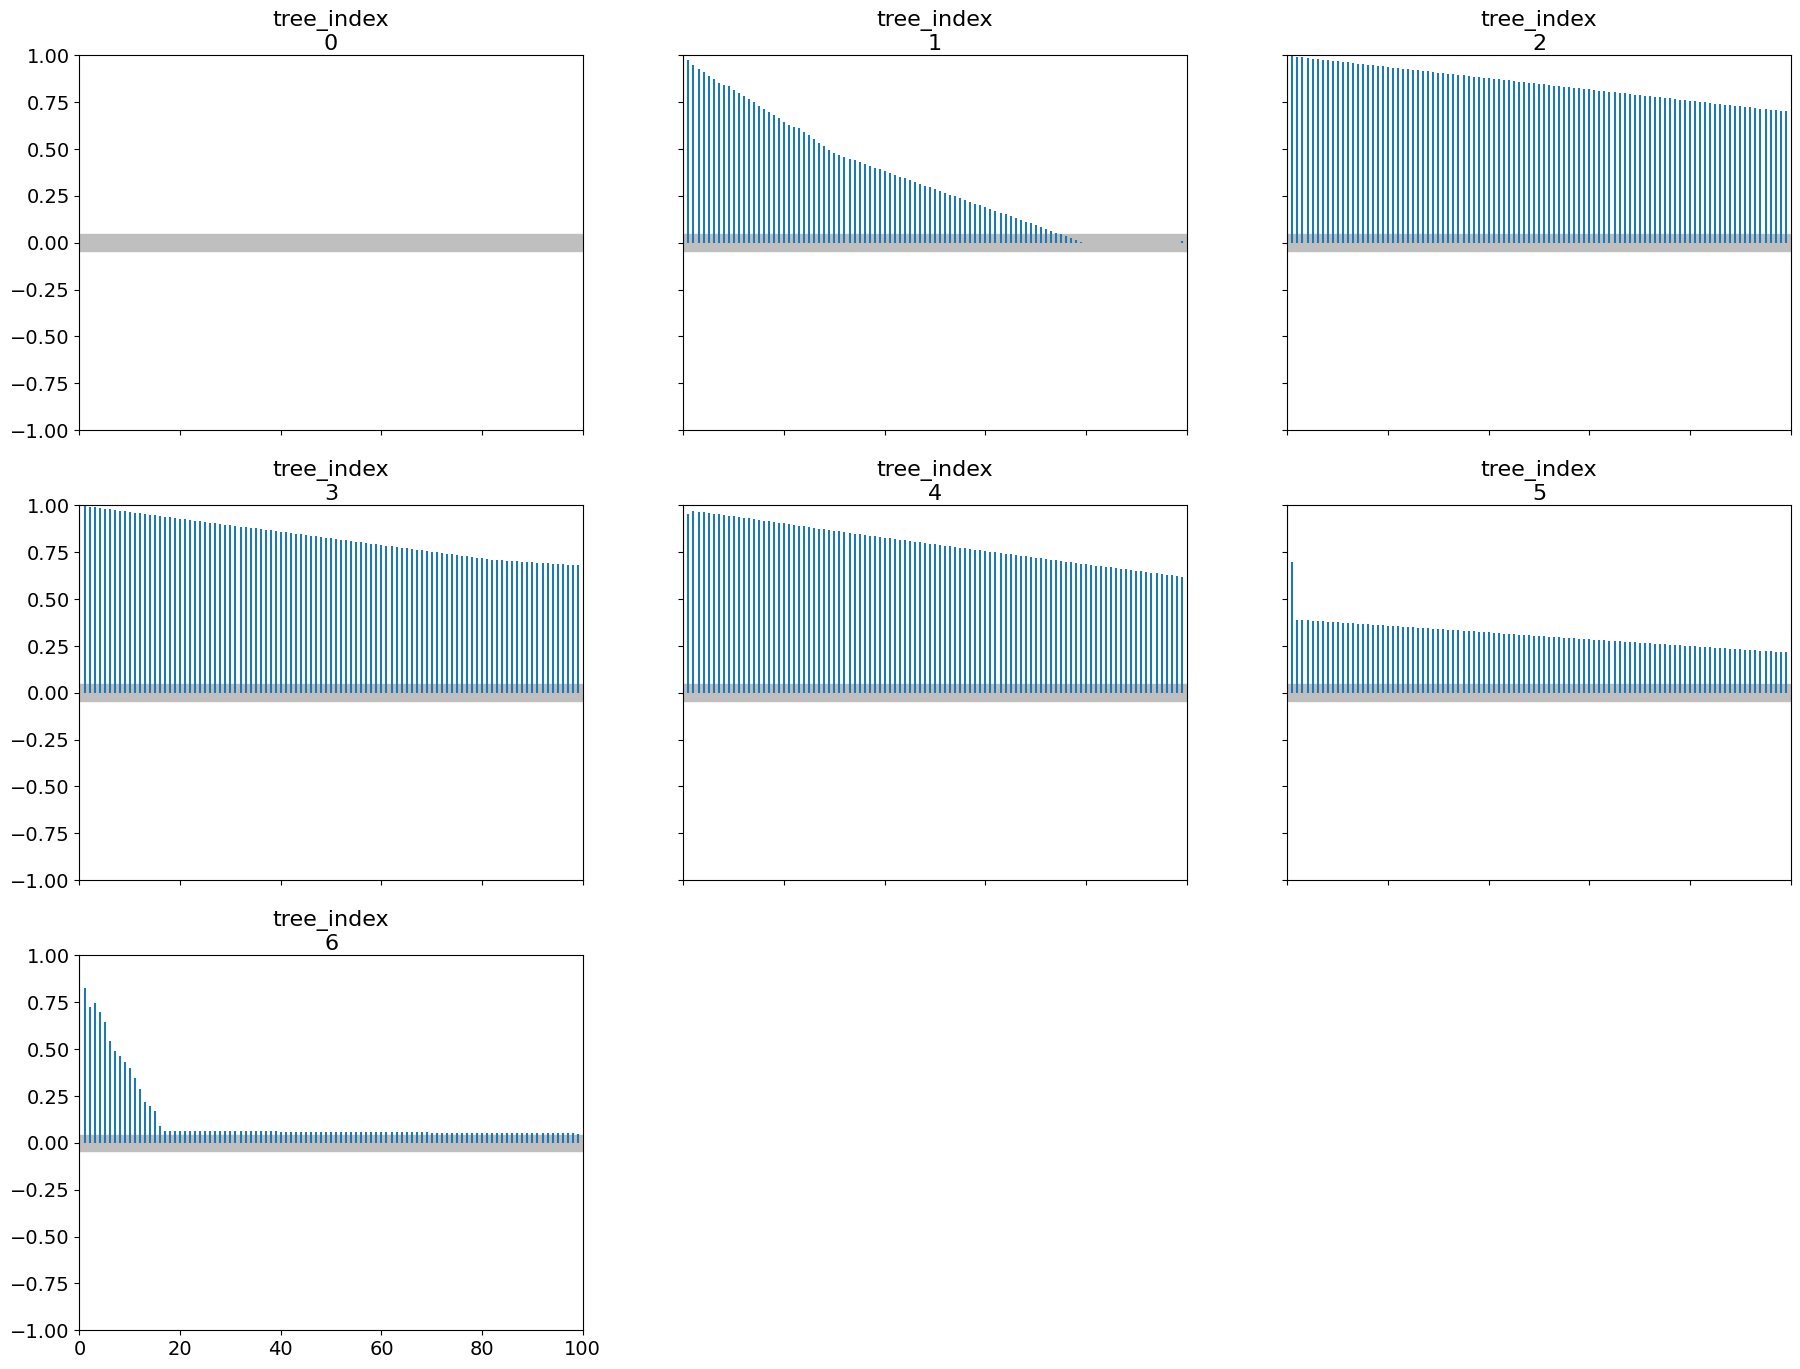

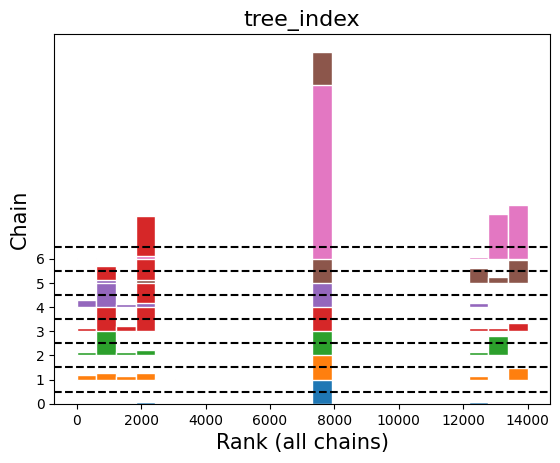

         119889 function calls (119886 primitive calls) in 0.074 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2000    0.024    0.000    0.061    0.000 749559422.py:159(g_sample_gaussian)
     2001    0.018    0.000    0.021    0.000 {method 'choice' of 'numpy.random._generator.Generator' objects}
     4000    0.007    0.000    0.012    0.000 linalg.py:2383(norm)
     8001    0.006    0.000    0.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     2000    0.005    0.000    0.006    0.000 1198053733.py:31(delta_loglik)
        1    0.003    0.003    0.073    0.073 1198053733.py:64(mh_density_dep_trees)
     4725    0.001    0.000    0.002    0.000 2356085309.py:17(_canon_split)
     9450    0.001    0.000    0.001    0.000 {built-in method builtins.sorted}
     2000    0.001    0.000    0.002    0.000 numerictypes.py:357(issubdtype)
     2000    0.001    0.000    0.001    0.000 {method 'random' of 'numpy.rando

In [ ]:
cache = {}

def split_loglik_star_sm(X, y, split, maxiter=100, eps=1e-12):
    """
    ℓ*(split) using statsmodels Logit (unpenalized MLE).
    Returns the node log-likelihood at the MLE (float).
    Degenerate targets (all 0/1) → return 0.0 (supremum in the limit).
    """
    A, B = split
    mask = np.isin(y, A + B)
    if not np.any(mask):
        return 0.0
    s = np.isin(y[mask], B).astype(int)

    if s.min() == s.max():
        return 0.0
    Xsub = sm.add_constant(X[mask], has_constant="add")
    try:
        res = sm.Logit(s, Xsub).fit(disp=0, maxiter=maxiter, method="newton")
        # Direct log-likelihood at the MLE:
        return float(res.llf)
    except PerfectSeparationError:
        print("Perfect Separation Error.")
        return 0.0
    except Exception:
        # Any other numerical hiccup: treat as saturated/flat
        print("Failed to do normal so we are fitting regularized.")
        p = np.clip(sm.Logit(s, Xsub).fit_regularized(alpha=1e-6, L1_wt=0.0, maxiter=maxiter).predict(), eps, 1-eps)
        return float((s*np.log(p) + (1-s)*np.log(1-p)).sum())
        
def delta_loglik(X, y, sig_T, sig_Tstar):
    """Compute log L(T*) - log L(T) by only evaluating splits in the symmetric difference."""
    add = sig_Tstar - sig_T
    add_vals = []
    rem = sig_T - sig_Tstar
    rem_vals = []
    
    for s in add:
        if s not in cache:
            log_lik = split_loglik_star_sm(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        add_vals.append(log_lik)
    for s in rem:
        if s not in cache:
            log_lik = split_loglik_star_sm(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        rem_vals.append(log_lik)
    
    return sum(add_vals) - sum(rem_vals)

def tree_loglik_idx(idx):
    tot = 0.0
    for s in tree_signatures(trees_defined[idx]):
        v = cache.get(s)
        if v is None:
            v = split_loglik_star_sm(X, y, s); cache[s] = v
        tot += v
    return tot

def mh_density_dep_trees(trees, X, y, n_samples, rng_seed=42):
    """
    trees: list of ND trees (tuples (left_set, right_set, left_child, right_child))
    g: proposal pmf over the library (shape M), fixed (independence)
    X (n,p), y (n,)
    Returns: indices trace (n_samples,), optional cache for reuse/diagnostics
    """
    rng = Generator(PCG64(rng_seed))
    # g = np.asarray(g, float)
    # log_g = np.log(g)
    M = len(trees)

    # Precompute signatures per tree (cheap, symbolic)
    sigs = [tree_signatures(T) for T in trees]
    # Initialize at the argmax under a quick heuristic (draw from g is fine too)
    i = int(rng.choice(M))

    trace = np.empty(n_samples, dtype=int)
    for t in range(n_samples):
        j, gdiff = g_sample_gaussian(Z, i, rng, scale)
        dLL = delta_loglik(X, y, sigs[i], sigs[j])
        logR = dLL + gdiff   # MH accept log-ratio
        if np.log(rng.random()) < min(0.0, logR):
            i = j
        trace[t] = i
    return trace, cache

seeds = [5, 11, 42, 50, 60, 69, 100]

traces = [mh_density_dep_trees(df_trees["tree"], X, y, 2000, rng_seed=s)[0]
          for s in seeds]
settled = [tr[-1] for tr in traces]  # or mode of each tail as above
best_idx = max(settled, key=lambda i: tree_loglik_idx(i))
best = trees_defined[best_idx]
print("Best across chains idx:", best_idx, "logL:", tree_loglik_idx(best_idx))
print("Best tree across chains idx:", trees_defined[best_idx])
if sorted(tuple(best)) == sorted(best_prev_tree):
    print("The best tree is found by MH!")
else:
    print("The best tree is NOT found by MH.")
    print("Best tree is:", best_prev_tree)

viz_mh_trace(traces, burn=0)

In [328]:
# Time my MH
%prun mh_density_dep_trees(df_trees["tree"], X, y, 2000, rng_seed=69)[0]

         119739 function calls (119736 primitive calls) in 0.089 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2000    0.027    0.000    0.069    0.000 749559422.py:159(g_sample_gaussian)
     2001    0.021    0.000    0.024    0.000 {method 'choice' of 'numpy.random._generator.Generator' objects}
     4000    0.008    0.000    0.014    0.000 linalg.py:2383(norm)
     8001    0.007    0.000    0.007    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     2000    0.006    0.000    0.007    0.000 1198053733.py:31(delta_loglik)
        1    0.003    0.003    0.088    0.088 1198053733.py:64(mh_density_dep_trees)
     9450    0.003    0.000    0.003    0.000 {built-in method builtins.sorted}
     4725    0.002    0.000    0.005    0.000 2356085309.py:17(_canon_split)
     5670    0.001    0.000    0.006    0.000 2356085309.py:29(<genexpr>)
      945    0.001    0.000    0.007    0.000 2356085309.py:23(tree_signatures)
  

## 🥪 MH - dependent sub trees

General: This one subs out individual nodes of the subtrees. 

Use candidate g(.) = 

In [ ]:
def check_label_fit(labels, y, coords):

    df_eval = pd.DataFrame({
        "score": y,
        "cluster": pd.Categorical(labels)   # no manual one-hot; just mark as categorical
    })

    # OLS with cluster fixed effects
    ols = smf.ols("score ~ C(cluster)", data=df_eval).fit()
    r2_in_sample = float(ols.rsquared)

    # ANOVA table (Type II)
    anova = sm.stats.anova_lm(ols, typ=2)

    # Sums of squares and dfs
    ss_between = float(anova.loc["C(cluster)", "sum_sq"])
    df_between = float(anova.loc["C(cluster)", "df"])
    ss_within  = float(anova.loc["Residual",   "sum_sq"])
    df_within  = float(anova.loc["Residual",   "df"])

    # Mean square within (pooled within-cluster variance estimate)
    ms_within = ss_within / df_within

    # Effect sizes:
    #   η²  = SS_between / (SS_between + SS_within)
    #   ω²  = (SS_between - df_between * MS_within) / (SS_total + MS_within)
    ss_total = ss_between + ss_within
    eta_sq   = ss_between / ss_total
    omega_sq = (ss_between - df_between * ms_within) / (ss_total + ms_within)

    # Optional: per-cluster descriptive stats
    per_cluster = df_eval.groupby("cluster")["score"].agg(["count", "mean", "std"]).sort_index()
    # print(per_cluster)

    # ----------------------------- (B) Mixed-effects ICC (random intercepts) -----------------------------
    # Model: score_ij = μ + u_j + ε_ij, with u_j ~ N(0, σ_u^2) for cluster j, ε_ij ~ N(0, σ^2)
    # ICC = σ_u^2 / (σ_u^2 + σ^2)
    md = sm.MixedLM.from_formula("score ~ 1", groups="cluster", data=df_eval)
    m  = md.fit(reml=True)  # REML for variance components

    # Between-cluster variance (random intercept variance)
    var_cluster = float(m.cov_re.iloc[0, 0])
    # Within-cluster (residual) variance
    var_resid   = float(m.scale)

    icc = var_cluster / (var_cluster + var_resid)

    sil = silhouette_score(coords, labels, metric="euclidean")

    return_values = {
        "r2_in_sample": r2_in_sample,
        "eta_sq": eta_sq,
        "omega_sq": omega_sq,
        "icc": icc,
        "sil": sil
    }

    return return_values

def embed_tree(df, embeding):
    if embeding == "bfs":
        # newicks = [str(breadth_first_splits(t)) for t in df["tree"]]
        df["tree_encoded"] = df["tree"].apply(lambda x: str(breadth_first_splits(x)))
    elif embeding == "dfs":
        # newicks = [str(depth_first_splits(t)) for t in df["tree"]]
        df["tree_encoded"] = df["tree"].apply(lambda x: str(depth_first_splits(x)))
    else:
        embeding = "newick"
        # newicks = [newick(t) for t in df["tree"]]
        df["tree_encoded"] = df["tree"].apply(newick)
    # newicks = sorted(newicks)
    # df['tree_encoded'] = newicks
    df = df.sort_values(by='tree_encoded')
    return df


NUMBER_OF_CLASSES = len(categories)

def split_analyzer(doc):
    splits = ast.literal_eval(doc) if isinstance(doc, str) else doc
    # max_depth = 4
    toks = []
    for d, (L, R) in enumerate(splits):

        L = tuple(sorted(L)) 
        R = tuple(sorted(R))   # order inside each side
        c = [L, R]
        c.sort(key=len, reverse=True)
        A = c[0]
        B = c[1]
        # depth_prefix = f"d{d}|"
        w = (NUMBER_OF_CLASSES - 2) - min(d, NUMBER_OF_CLASSES - 3)
        new = NUMBER_OF_CLASSES - d
        toks.extend([f"split:{A}|{B}"])

        toks.extend([f"sz:{len(A)}|{len(B)}"]*new)

        toks.extend([f"group:{A}"]*len(A))
        toks.extend([f"group:{B}"]*len(B))

        # toks.extend([f"group:{A}"])
        # toks.extend([f"group:{B}"])
        # # toks.append(f"group:{B}")
        
        # encourage grouping via co-membership pairs (repeatable across trees)
        for side in (A, B):
            for i, j in itertools.combinations(side, 2):
                toks.extend([f"pair:{i}-{j}"])
                # toks.extend([f"pair:{i}-{j}"]*(d+1))
    return toks

embeding = "bfs"

n_clusters=15
ngram_range=(2,4)
note=""
# vectorizer: encourage overlap, trim one-offs
vec = TfidfVectorizer(
    analyzer=split_analyzer,
)
    
info_df, coords = map_all_trees(df_trees, embeding=embeding, vec=vec)
df_trees["x_coord"] = coords[:,0]
df_trees["y_coord"] = coords[:,1]

# To increase acceptance rate, decrease power, increase k and eps
power=1
k=3

Z = df_trees[['x_coord','y_coord']].to_numpy(float)
nn = NearestNeighbors(n_neighbors=k+1).fit(Z)
d, _ = nn.kneighbors(Z, n_neighbors=k+1)   # first neighbor is self
dk = d[:, k]                               # 
D = 1.0 / (dk + 1e-2)**power
g = D / D.sum()

df_trees['prob_dist'] = g

In [ ]:
cache = {}

def split_loglik_star_sm(X, y, split, maxiter=100, eps=1e-12):
    """
    ℓ*(split) using statsmodels Logit (unpenalized MLE).
    Returns the node log-likelihood at the MLE (float).
    Degenerate targets (all 0/1) → return 0.0 (supremum in the limit).
    """
    A, B = split
    mask = np.isin(y, A + B)
    if not np.any(mask):
        return 0.0
    s = np.isin(y[mask], B).astype(int)

    if s.min() == s.max():
        return 0.0
    Xsub = sm.add_constant(X[mask], has_constant="add")
    try:
        res = sm.Logit(s, Xsub).fit(disp=0, maxiter=maxiter, method="newton")
        # Direct log-likelihood at the MLE:
        return float(res.llf)
    except PerfectSeparationError:
        print("Perfect Separation Error.")
        return 0.0
    except Exception:
        # Any other numerical hiccup: treat as saturated/flat
        print("Failed to do normal so we are fitting regularized.")
        p = np.clip(sm.Logit(s, Xsub).fit_regularized(alpha=1e-6, L1_wt=0.0, maxiter=maxiter).predict(), eps, 1-eps)
        return float((s*np.log(p) + (1-s)*np.log(1-p)).sum())
        
def delta_loglik(X, y, sig_T, sig_Tstar):
    """Compute log L(T*) - log L(T) by only evaluating splits in the symmetric difference."""
    add = sig_Tstar - sig_T
    add_vals = []
    rem = sig_T - sig_Tstar
    rem_vals = []
    
    for s in add:
        if s not in cache:
            log_lik = split_loglik_star_sm(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        add_vals.append(log_lik)
    for s in rem:
        if s not in cache:
            log_lik = split_loglik_star_sm(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        rem_vals.append(log_lik)
    
    return sum(add_vals) - sum(rem_vals)

def tree_loglik_idx(idx):
    tot = 0.0
    for s in tree_signatures(trees_defined[idx]):
        v = cache.get(s)
        if v is None:
            v = split_loglik_star_sm(X, y, s); cache[s] = v
        tot += v
    return tot

# --- Independence-chain MH over a library of trees (computes on the fly) ----
def mh_density_trees(trees, g, X, y, n_samples, rng_seed=42):
    """
    trees: list of ND trees (tuples (left_set, right_set, left_child, right_child))
    g: proposal pmf over the library (shape M), fixed (independence)
    X (n,p), y (n,)
    Returns: indices trace (n_samples,), optional cache for reuse/diagnostics
    """
    rng = Generator(PCG64(rng_seed))
    g = np.asarray(g, float)
    log_g = np.log(g)
    M = len(trees)

    # Precompute signatures per tree (cheap, symbolic)
    sigs = [tree_signatures(T) for T in trees]
    # Initialize at the argmax under a quick heuristic (draw from g is fine too)
    i = int(rng.choice(M, p=g))

    trace = np.empty(n_samples, dtype=int)
    for t in range(n_samples):
        j = int(rng.choice(M, p=g))  # independence proposal
        dLL = delta_loglik(X, y, sigs[i], sigs[j])
        logR = dLL + (log_g[i] - log_g[j])   # MH accept log-ratio
        if np.log(rng.random()) < min(0.0, logR):
            i = j
        trace[t] = i
    return trace, cache

seeds = [5, 11, 42, 50, 60, 69, 100]
traces = [mh_density_trees(df_trees["tree"], df_trees["prob_dist"], X, y, 100, rng_seed=s)[0]
          for s in seeds]
settled = [tr[-1] for tr in traces]  # or mode of each tail as above
best_idx = max(settled, key=lambda i: tree_loglik_idx(i))
best = trees_defined[best_idx]
print("Best across chains idx:", best_idx, "logL:", tree_loglik_idx(best_idx))
print("Best tree across chains idx:", trees_defined[best_idx])
if sorted(tuple(best)) == sorted(best_prev_tree):
    print("The best tree is found by MH!")
else:
    print("The best tree is NOT found by MH.")
    print("Best tree is:", best_prev_tree)

viz_mh_trace(traces, burn=0)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from numpy.random import Generator, PCG64
import numpy as np
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning
import warnings

def _canon_split(left_set, right_set):
    """Return a canonical (A,B) tuple so (A,B)==(B,A) for hashing/caching."""
    A = tuple(sorted(left_set))
    B = tuple(sorted(right_set))
    return (A, B) if A <= B else (B, A)

def tree_signatures(tree):
    """
    Collect canonical split signatures for all internal nodes of an ND.
    Tree node format: (left_set, right_set, left_child, right_child), leaves have children None.
    """
    sigs, stack = set(), [tree]
    while stack:
        left, right, lc, rc = stack.pop()
        if lc is not None or rc is not None:
            sigs.add(_canon_split(left, right))
            if lc is not None: stack.append(lc)
            if rc is not None: stack.append(rc)
    return frozenset(sigs)

# --- Per-split profile log-likelihood (unpenalized logistic) ----

def split_loglik_star(X, y, split, eps=1e-12, max_iter=200):
    """
    ℓ*(split) = nodewise Bernoulli-logistic MLE log-likelihood for a split = (A,B).
    Uses scikit-learn (penalty='none') to fit; then computes the exact log-lik at the MLE.
    Handles degenerate targets by returning 0.0 (supremum attained in the limit).
    """
    A, B = split
    mask = np.isin(y, A + B)  # rows reaching this node
    if not np.any(mask):
        return 0.0
    s = np.isin(y[mask], A).astype(int)
    # Degenerate (all 0 or all 1): supremum log-lik = 0
    if s.min() == s.max():
        return 0.0

    Xsub = X[mask]
    lr = LogisticRegression(penalty='none', solver='lbfgs', fit_intercept=True, max_iter=max_iter)
    lr.fit(Xsub, s)
    p = lr.predict_proba(Xsub)[:, 1]
    p = np.clip(p, eps, 1 - eps)  # numerical safety (unpenalized can separate)
    ll = float((s * np.log(p) + (1 - s) * np.log(1 - p)).sum())
    return ll

# --- Delta log-likelihood via symmetric-difference cancellation ----
cache = {}

def delta_loglik(X, y, sig_T, sig_Tstar):
    """Compute log L(T*) - log L(T) by only evaluating splits in the symmetric difference."""
    add = sig_Tstar - sig_T
    add_vals = []
    rem = sig_T - sig_Tstar
    rem_vals = []
    
    for s in add:
        if s not in cache:
            log_lik = split_loglik_star(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        add_vals.append(log_lik)
    for s in rem:
        if s not in cache:
            log_lik = split_loglik_star(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        rem_vals.append(log_lik)
    
    return sum(add_vals) - sum(rem_vals)

# --- Independence-chain MH over a library of trees (computes on the fly) ----

def mh_independence_over_trees(trees, g, X, y, n_samples, rng_seed=42):
    """
    trees: list of ND trees (tuples (left_set, right_set, left_child, right_child))
    g: proposal pmf over the library (shape M), fixed (independence)
    X (n,p), y (n,)
    Returns: indices trace (n_samples,), optional cache for reuse/diagnostics
    """
    rng = Generator(PCG64(rng_seed))
    # if rng is None:
    #     rng = np.random.default_rng()
    g = np.asarray(g, float)
    g = g / g.sum()
    log_g = np.log(g)
    M = len(trees)

    # Precompute signatures per tree (cheap, symbolic)
    sigs = [tree_signatures(T) for T in trees]

    # Initialize at the argmax under a quick heuristic (draw from g is fine too)
    i = int(np.argmax(g))

    trace = np.empty(n_samples, dtype=int)
    for t in range(n_samples):
        j = int(rng.choice(M, p=g))  # independence proposal
        dLL = delta_loglik(X, y, sigs[i], sigs[j])
        logR = dLL + (log_g[i] - log_g[j])   # MH accept log-ratio
        if np.log(rng.random()) < min(0.0, logR):
            i = j
        trace[t] = i
    return trace, cache


In [ ]:
import numpy as np, math

# ----- small ND helpers -----
def classset(n): 
    if n is None: return set()
    L,R,_,_ = n; return L|R

def internal_nodes(T):
    out, stk = [], [((), T)]
    while stk:
        p, n = stk.pop()
        if n is None: continue
        L,R,lc,rc = n
        if lc is None and rc is None: continue
        out.append((p,n))
        if lc is not None: stk.append((p+('L',), lc))
        if rc is not None: stk.append((p+('R',), rc))
    return out

def replace_subtree(T, path, new_sub):
    if not path: return new_sub
    L,R,lc,rc = T
    if path[0]=='L': return (L,R, replace_subtree(lc, path[1:], new_sub), rc)
    else:            return (L,R, lc, replace_subtree(rc, path[1:], new_sub))

def W_sum(T, alpha=1.0):
    return sum((len(classset(n))**(-alpha)) for _,n in internal_nodes(T))

def logC(m,k):
    return math.lgamma(m+1)-math.lgamma(k+1)-math.lgamma(m-k+1)

# ----- NNI (very compact) -----
def eligible_pivots(T):
    piv, stk = [], [((), T)]
    while stk:
        p, n = stk.pop()
        if n is None: continue
        L,R,a,b = n
        if a is not None: stk.append((p+('L',), a))
        if b is not None: stk.append((p+('R',), b))
        if a and b and (a[2] or a[3]) and (b[2] or b[3]):
            piv.append((p,n))
    return piv

def nni_alts(node):
    Lp,Rp,a,b = node
    aL,aR,bL,bR = a[2],a[3],b[2],b[3]
    def pack(x,y): return (classset(x), classset(y), x, y)
    alt1 = ( classset(pack(aL,bL)), classset(pack(aR,bR)), pack(aL,bL), pack(aR,bR) )
    alt2 = ( classset(pack(aL,bR)), classset(pack(aR,bL)), pack(aL,bR), pack(aR,bL) )
    # parent L,R are implied by children; delta_loglik uses per-node splits of children
    return alt1, alt2

def propose_nni(T, rng):
    piv = eligible_pivots(T)
    if not piv: return T, 0.0
    m = len(piv)
    path, node = piv[int(rng.integers(m))]
    alt1, alt2 = nni_alts(node)
    T_star = replace_subtree(T, path, alt1 if int(rng.integers(2))==0 else alt2)
    m_star = len(eligible_pivots(T_star))
    return T_star, (np.log(m)-np.log(m_star))

# ----- size-guided subtree (3-point k around reference size) -----
def _k_probs3(m, a_ref):
    C = []
    for k,w in ((a_ref-1,0.25),(a_ref,0.5),(a_ref+1,0.25)):
        if 1 <= k <= m-1: C.append((k,w))
    s = sum(w for _,w in C)
    return [(k,w/s) for k,w in C] if s>0 else [(max(1,min(m-1,a_ref)),1.0)]

def gen_subtree_size_guided(S, ref_sub, rng):
    """Generate subtree ~ size-guided and return (subtree, log g_size(new|ref))."""
    S = tuple(sorted(S)); m = len(S)
    if m<=1: return None, 0.0
    a_ref = len(classset(ref_sub[2]))  # size of reference left child
    choices = _k_probs3(m, a_ref)
    ks, ps = zip(*choices)
    pick = int(rng.choice(len(ks), p=ps))
    k = ks[pick]; p_k = ps[pick]
    A = set(rng.choice(S, size=k, replace=False)); B = set(S)-A
    lc, lgL = gen_subtree_size_guided(sorted(A), ref_sub[2], rng)
    rc, lgR = gen_subtree_size_guided(sorted(B), ref_sub[3], rng)
    return (A,B,lc,rc), (math.log(p_k) - logC(m,k) + lgL + lgR)

def log_g_size_given_ref(target_sub, ref_sub):
    """Evaluate log g_size(target|ref) (no sampling)."""
    if target_sub is None: return 0.0
    L,R,lc,rc   = target_sub
    m, k        = len(L|R), len(L)
    a_ref       = len(classset(ref_sub[2]))
    choices     = _k_probs3(m, a_ref)
    p_k         = dict(choices).get(k, 0.0)
    if p_k<=0: return -np.inf
    return (math.log(p_k) - logC(m,k)
            + log_g_size_given_ref(lc, ref_sub[2])
            + log_g_size_given_ref(rc, ref_sub[3]))

def propose_subtree_size_guided(T, rng, alpha=1.0):
    nodes = internal_nodes(T)
    if not nodes: return T, 0.0
    sizes = np.array([len(classset(n)) for _,n in nodes], float)
    p = sizes**(-alpha); p /= p.sum()
    idx = int(rng.choice(len(nodes), p=p))
    path, old_sub = nodes[idx]
    new_sub, lg_new_given_old = gen_subtree_size_guided(classset(old_sub), old_sub, rng)
    T_star = replace_subtree(T, path, new_sub)
    # reverse term needs log g_size(old | new)
    lg_old_given_new = log_g_size_given_ref(old_sub, new_sub)
    lq = (np.log(W_sum(T,alpha)) - np.log(W_sum(T_star,alpha))) + (lg_old_given_new - lg_new_given_old)
    return T_star, lq

# ----- mixed proposal: NNI with prob eta, else size-guided subtree -----
def propose_mixed_size(T, rng, eta=0.7, alpha=1.0):
    return propose_nni(T, rng) if rng.random()<eta else propose_subtree_size_guided(T, rng, alpha)


In [ ]:
def _canon_split(left_set, right_set):
    """Return a canonical (A,B) tuple so (A,B)==(B,A) for hashing/caching."""
    A = tuple(sorted(left_set))
    B = tuple(sorted(right_set))
    return (A, B) if A <= B else (B, A)

def tree_signatures(tree):
    """
    Collect canonical split signatures for all internal nodes of an ND.
    Tree node format: (left_set, right_set, left_child, right_child), leaves have children None.
    """
    sigs, stack = set(), [tree]
    while stack:
        left, right, lc, rc = stack.pop()
        if lc is not None or rc is not None:
            sigs.add(_canon_split(left, right))
            if lc is not None: stack.append(lc)
            if rc is not None: stack.append(rc)
    return frozenset(sigs)

def split_loglik_star_sm(X, y, split, maxiter=100, eps=1e-12):
    """
    ℓ*(split) using statsmodels Logit (unpenalized MLE).
    Returns the node log-likelihood at the MLE (float).
    Degenerate targets (all 0/1) → return 0.0 (supremum in the limit).
    """
    A, B = split
    mask = np.isin(y, A + B)
    if not np.any(mask):
        return 0.0
    s = np.isin(y[mask], A).astype(int)
    if s.min() == s.max():
        return 0.0

    Xsub = sm.add_constant(X[mask], has_constant="add")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        try:
            res = sm.Logit(s, Xsub).fit(disp=0, maxiter=maxiter, method="newton")
            # Direct log-likelihood at the MLE:
            return float(res.llf)
        except PerfectSeparationError:
            return 0.0
        except Exception:
            # Any other numerical hiccup: treat as saturated/flat
            print("Failed to do normal so we are fitting regularized.")
            p = np.clip(sm.Logit(s, Xsub).fit_regularized(alpha=1e-12, disp=0).predict(), eps, 1-eps)
            return float((s*np.log(p) + (1-s)*np.log(1-p)).sum())

def delta_loglik(X, y, sig_T, sig_Tstar):
    """Compute log L(T*) - log L(T) by only evaluating splits in the symmetric difference."""
    add = sig_Tstar - sig_T
    add_vals = []
    rem = sig_T - sig_Tstar
    rem_vals = []
    
    for s in add:
        if s not in cache:
            log_lik = split_loglik_star(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        add_vals.append(log_lik)
    for s in rem:
        if s not in cache:
            log_lik = split_loglik_star(X, y, s)
            cache[s] = log_lik
        else: 
            log_lik = cache[s]
        rem_vals.append(log_lik)
    
    return sum(add_vals) - sum(rem_vals)

# --- Independence-chain MH over a library of trees (computes on the fly) ----

def mh_independence_over_trees(trees, g, X, y, n_samples, rng_seed=42):
    """
    trees: list of ND trees (tuples (left_set, right_set, left_child, right_child))
    g: proposal pmf over the library (shape M), fixed (independence)
    X (n,p), y (n,)
    Returns: indices trace (n_samples,), optional cache for reuse/diagnostics
    """
    rng = Generator(PCG64(rng_seed))
    g = np.asarray(g, float)
    g = g / g.sum()
    log_g = np.log(g)
    M = len(trees)

    # Precompute signatures per tree (cheap, symbolic)
    sigs = [tree_signatures(T) for T in trees]

    # Initialize at the argmax under a quick heuristic (draw from g is fine too)
    i = int(np.argmax(g))

    trace = np.empty(n_samples, dtype=int)
    for t in range(n_samples):
        j = int(rng.choice(M, p=g))  # independence proposal
        dLL = delta_loglik(X, y, sigs[i], sigs[j])
        logR = dLL + (log_g[i] - log_g[j])   # MH accept log-ratio
        if np.log(rng.random()) < min(0.0, logR):
            i = j
        trace[t] = i
    return trace, cache

# Visualising Chains

In [73]:
# ---- Standard Bayes diagnostics (PyMC-style) + tiny Bokeh dashboard ----
import numpy as np
import arviz as az
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import column

def to_idata(traces):
    """Accept a 1D array or a list of 1D arrays -> ArviZ InferenceData."""
    if isinstance(traces, (list, tuple)) and hasattr(traces[0], "__len__"):
        arr = np.stack([np.asarray(t) for t in traces], axis=0)   # (chain, draw)
    else:
        arr = np.asarray(traces)[None, :]                         # (1, draw)
    return az.from_dict(posterior={"tree_index": arr})

def viz_mh_trace(trace, burn=0, top_k=20):
    # 1) ArviZ: trace, posterior, autocorr, rank, summary (R-hat/ESS if multiple chains)
    idata = to_idata(trace)
    az.plot_trace(idata, var_names="tree_index")
    az.plot_posterior(idata, var_names="tree_index")
    az.plot_autocorr(idata, var_names="tree_index")
    az.plot_rank(idata, var_names="tree_index")
    print(az.summary(idata, var_names="tree_index", round_to=2))

    # 2) Acceptance rate + compact Bokeh dashboard (interactive)
    tr = np.asarray(trace)
    acc = (tr[1:] != tr[:-1]).mean() if tr.size > 1 else np.nan
    print(f"Acceptance rate: {acc:.3f}")

    it  = np.arange(tr.size)
    acc_flag = np.r_[False, tr[1:] != tr[:-1]] if tr.size > 1 else np.array([False])
    src = ColumnDataSource(dict(it=it, idx=tr, acc=acc_flag))
    p1 = figure(title="MCMC trace (tree index)", width=800, height=260,
                tools="xpan,xwheel_zoom,reset,hover",
                tooltips=[("iter","@it"),("index","@idx"),("accepted","@acc")])
    p1.line('it','idx', source=src); p1.circle('it','idx', source=src, size=3, alpha=0.6)

    post = tr[burn:]
    uniq, counts = np.unique(post, return_counts=True)
    order = np.argsort(counts)[::-1][:top_k]
    x = [str(u) for u in uniq[order]]; y = counts[order] / counts.sum()
    src2 = ColumnDataSource(dict(idx=x, p=y))
    p2 = figure(x_range=x, title=f"Posterior mass (top {top_k})", width=800, height=260,
                tools="hover", tooltips=[("tree","@idx"),("mass","@p{0.000}")])
    p2.vbar(x='idx', top='p', source=src2, width=0.9)

    show(column(p1, p2))
    return idata, acc
